# Compare against census data

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [2]:
font = {'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

In [3]:
from PopSynthesis.Benchmark.CompareCensus.utils import convert_full_to_marg_count, impute_new_marg

In [4]:
# Population data and the census data, also extract the total and studied attributes
folder_loc = "data/synpop_related"
to_analyse_data = {
    # "SAA_hhsz_rm30": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm0_add_zero_cells.csv",
    # "SAA_hhsz_rm0": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm30_add_zero_cells.csv",
    # "SAA_hhsz_zerocellstill": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm30_missing_zero_cells.csv",
    "SAA_BN_pool": "SAA_HH_paper_BN_IPL_ordered_rm30_2.csv",
    "SAA_seed_addzero": "SAA_HH_paper_oriseed_IPL_ordered_rm30_addzero.csv",
    "SAA_seed_misszero": "SAA_HH_paper_oriseed_IPL_ordered_rm30_misszero.csv",
    "IPF_normal": "IPF_using_normals_seed.csv",
    "IPF_fromBN": "IPF_BN_pool2.csv",
    "WGAN": "wgan_synthetic_population.csv",
    # "WGAN_Copula": "wgan_copula_syn.csv", 
    "Census": "hh_marginals_ipu.csv", # Main one always there
}
assert "Census" in to_analyse_data

In [5]:
# Reading the file to df
processed_analyse_data = {name: pd.read_csv(os.path.join(folder_loc, file)) for name, file in to_analyse_data.items() if name != "Census"}

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_28920\2470389799.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  processed_analyse_data = {name: pd.read_csv(os.path.join(folder_loc, file)) for name, file in to_analyse_data.items() if name != "Census"}


In [6]:
census_data = pd.read_csv(os.path.join(folder_loc, to_analyse_data["Census"]), header=[0,1])
census_data

zone_id        sample_geog hhsize                               \
    Unnamed: 0_level_1 Unnamed: 1_level_1      1     2     3    4    5   6  7   
0                 3000                  2  10393  8524  2026  656  118  27  4   
1                 3002                  2   1035  1019   190  101   38   9  0   
2                 3003                  2   1504  1591   476  223   40  11  7   
3                 3004                  2   2566  2382   511  227   33   6  5   
4                 3006                  2   5113  5033  1280  414   59  13  8   
..                 ...                ...    ...   ...   ...  ...  ...  .. ..   
686               3990                  2      6    20     8    4    3   0  0   
687               3991                  2     37    65    16   19   10   9  0   
688               3992                  2    134   201    72   60   24   9  0   
689               3995                  2   1663  1834   629  451  228  73  8   
690               3996                  2    806  1176   251  299  137  31  6   

         ...      hhinc totalvehs                              owndwell  \
     8+  ... Nil income         0     1     2    3   4+ Being Purchased   
0    58  ...       1916     14688  5445   861  397  415            2453   
1    55  ...         42       478  1268   545   89   67             434   
2    55  ...        159      1401  1937   420   93   56             797   
3    55  ...        172      1198  3442   882  168   95            1207   
4    58  ...        435      4725  5884  1026  193  150            2136   
..   ..  ...        ...       ...   ...   ...  ...  ...             ...   
686  55  ...          3        13    12    30   25   16              16   
687  55  ...          6        20    46    66   42   37              51   
688  55  ...          9        12   153   218   93   79             229   
689  58  ...         87       380  1949  1692  585  338            1326   
690  59  ...         55        88  1040  1207  298  132             690   

                                             
    Being Rented Fully Owned Something Else  
0          16601        2284            468  
1           1298         673             42  
2           2548         463             99  
3           3212        1268             98  
4           8092        1537            213  
..           ...         ...            ...  
686            0          22             58  
687           17          67             76  
688           55         192             79  
689         1150        2316            152  
690          494        1525             56  

[691 rows x 46 columns]

In [7]:
# Extract the total and studied attributes
special_cols = {"zone_id", "sample_geog"}
studied_atts = set(census_data.columns.get_level_values(0)) - special_cols
# census_data.columns = census_data.columns.to_flat_index()
zone_id_col = [col for col in census_data.columns if col[0] == "zone_id"][0]
other_cols = [col for col in census_data.columns if col[0] in special_cols and col[0] != "zone_id"]
assert census_data[zone_id_col].nunique() == census_data.shape[0]
census_data = census_data.set_index(zone_id_col)
census_data = census_data.drop(columns=other_cols)
census_data

hhsize                                   \
                                   1     2     3    4    5   6  7  8+   
(zone_id, Unnamed: 0_level_1)                                           
3000                           10393  8524  2026  656  118  27  4  58   
3002                            1035  1019   190  101   38   9  0  55   
3003                            1504  1591   476  223   40  11  7  55   
3004                            2566  2382   511  227   33   6  5  55   
3006                            5113  5033  1280  414   59  13  8  58   
...                              ...   ...   ...  ...  ...  .. ..  ..   
3990                               6    20     8    4    3   0  0  55   
3991                              37    65    16   19   10   9  0  55   
3992                             134   201    72   60   24   9  0  55   
3995                            1663  1834   629  451  228  73  8  58   
3996                             806  1176   251  299  137  31  6  59   

                                      dwelltype          ...      hhinc  \
                              Flat or Apartment Missing  ... Nil income   
(zone_id, Unnamed: 0_level_1)                            ...              
3000                                      21546     128  ...       1916   
3002                                       1877       9  ...         42   
3003                                       3187       6  ...        159   
3004                                       5741      27  ...        172   
3006                                      11783      40  ...        435   
...                                         ...     ...  ...        ...   
3990                                          0       0  ...          3   
3991                                          0       0  ...          6   
3992                                          0       0  ...          9   
3995                                         25       8  ...         87   
3996                                         12       4  ...         55   

                              totalvehs                              owndwell  \
                                      0     1     2    3   4+ Being Purchased   
(zone_id, Unnamed: 0_level_1)                                                   
3000                              14688  5445   861  397  415            2453   
3002                                478  1268   545   89   67             434   
3003                               1401  1937   420   93   56             797   
3004                               1198  3442   882  168   95            1207   
3006                               4725  5884  1026  193  150            2136   
...                                 ...   ...   ...  ...  ...             ...   
3990                                 13    12    30   25   16              16   
3991                                 20    46    66   42   37              51   
3992                                 12   153   218   93   79             229   
3995                                380  1949  1692  585  338            1326   
3996                                 88  1040  1207  298  132             690   

                                                                       
                              Being Rented Fully Owned Something Else  
(zone_id, Unnamed: 0_level_1)                                          
3000                                 16601        2284            468  
3002                                  1298         673             42  
3003                                  2548         463             99  
3004                                  3212        1268             98  
3006                                  8092        1537            213  
...                                    ...         ...            ...  
3990                                     0          22             58  
3991                                    17          67             76  
3992                         

In [8]:
zonal_sum = census_data.sum(axis=1) / len(studied_atts)
zonal_sum

(zone_id, Unnamed: 0_level_1)
3000    21806.0
3002     2447.0
3003     3907.0
3004     5785.0
3006    11978.0
         ...   
3990       96.0
3991      211.0
3992      555.0
3995     4944.0
3996     2765.0
Length: 691, dtype: float64

## Start processing

In [9]:
marg_formatted_data = {name: convert_full_to_marg_count(df) for name, df in processed_analyse_data.items()}
marg_formatted_data = {name: impute_new_marg(census_data, df) for name, df in marg_formatted_data.items()}

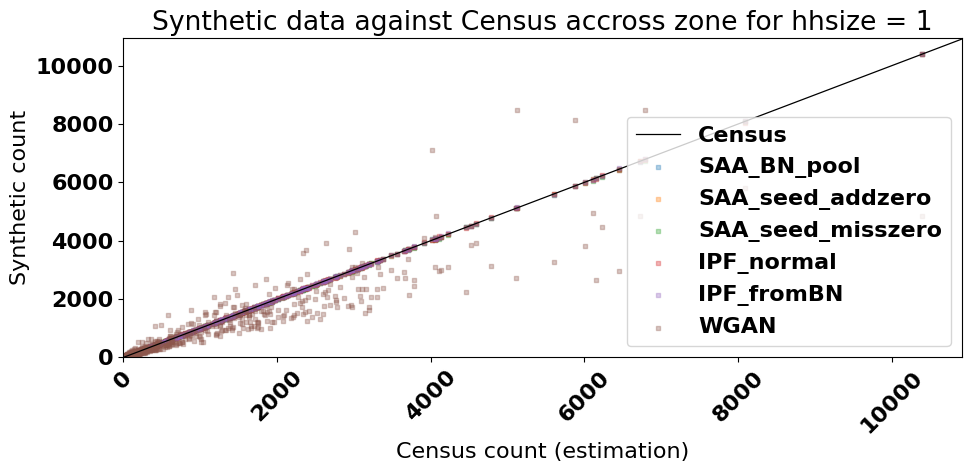

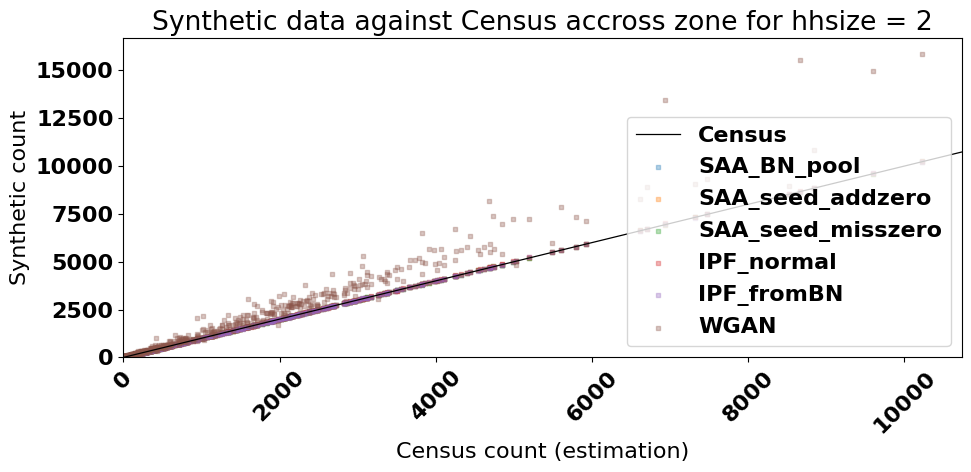

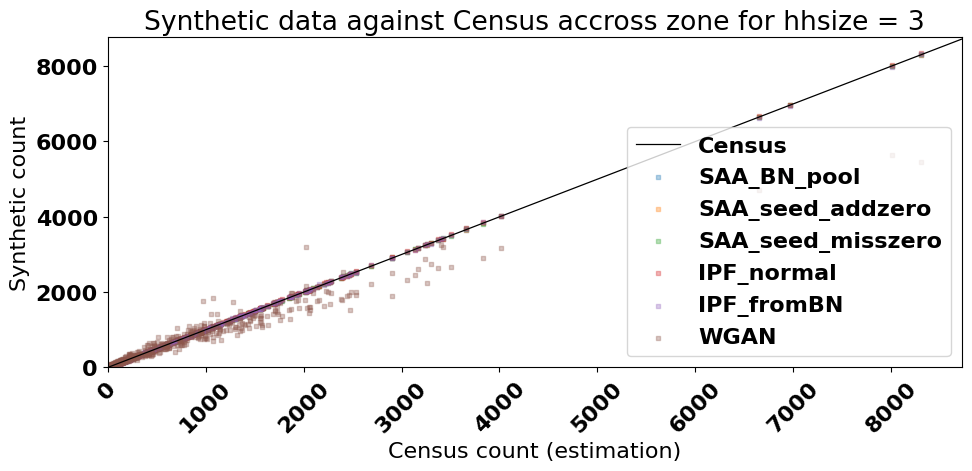

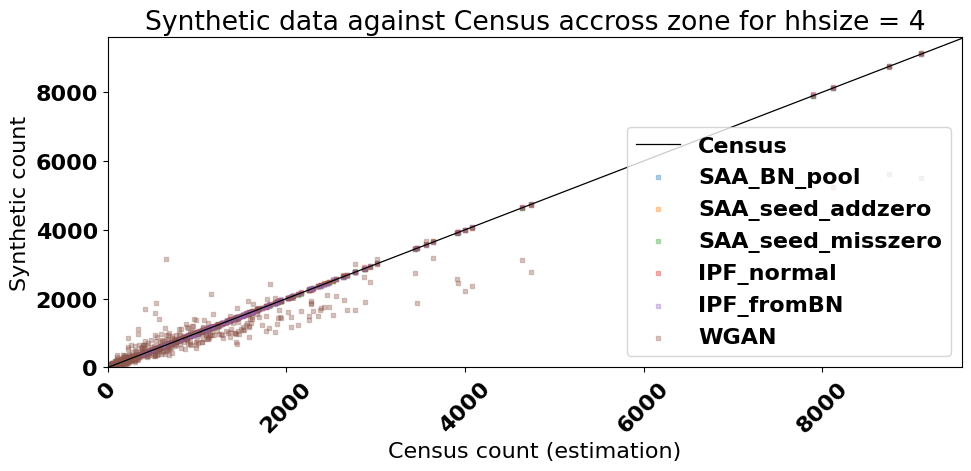

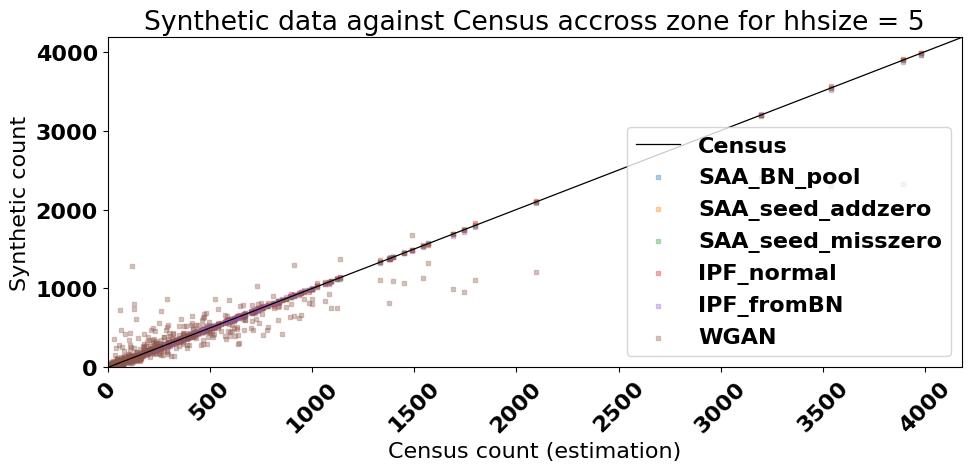

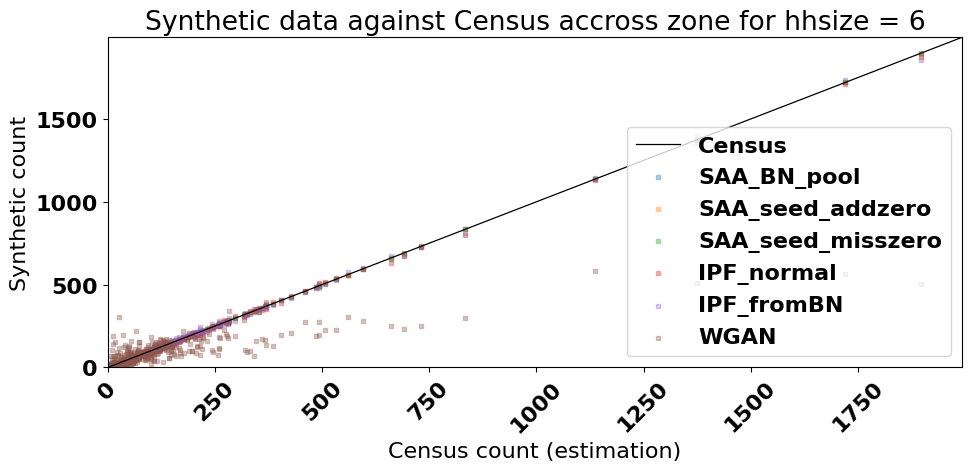

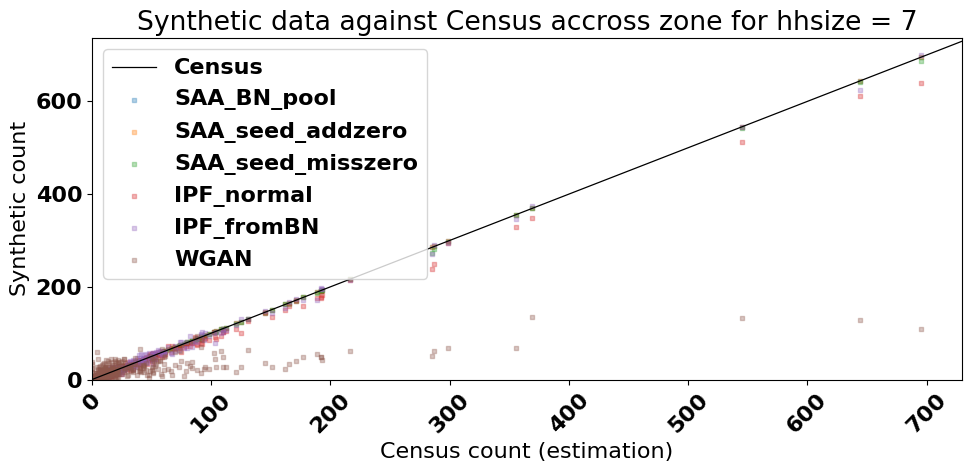

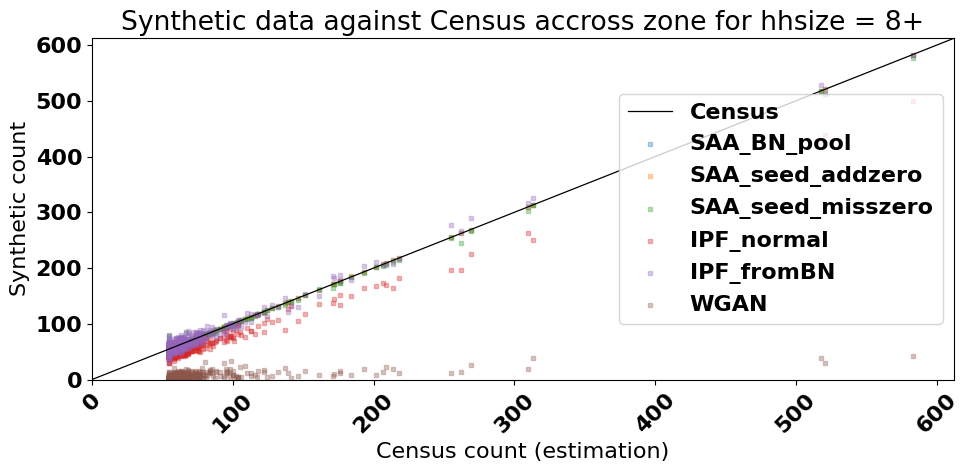

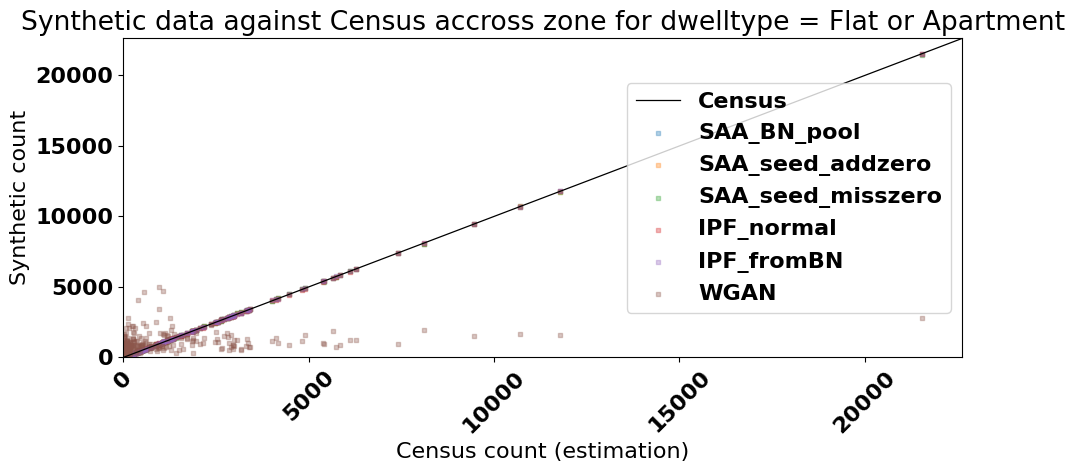

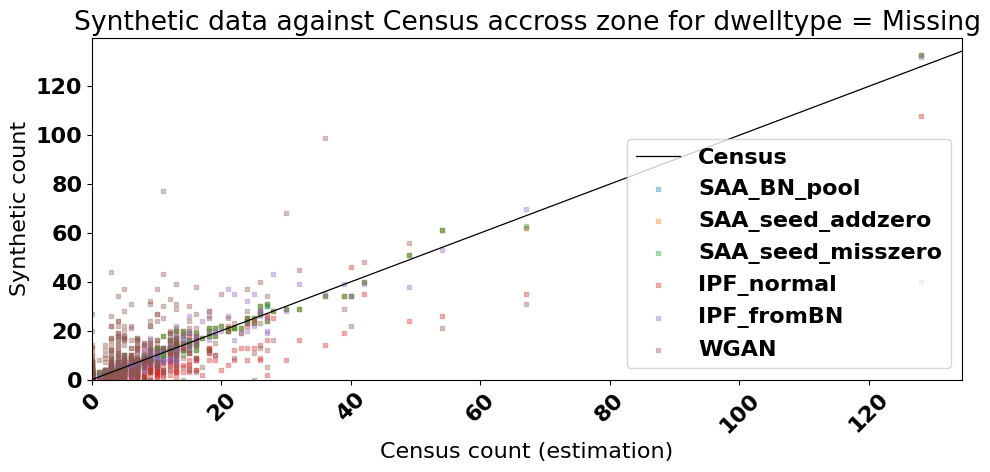

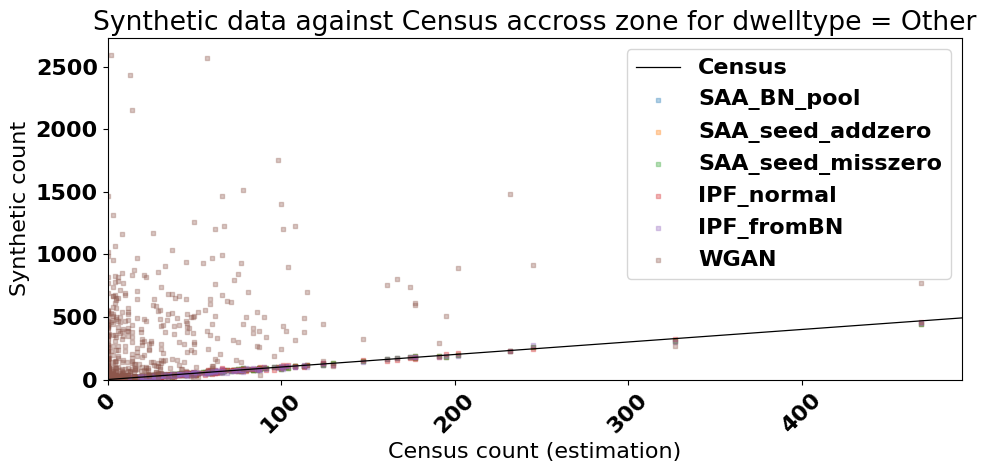

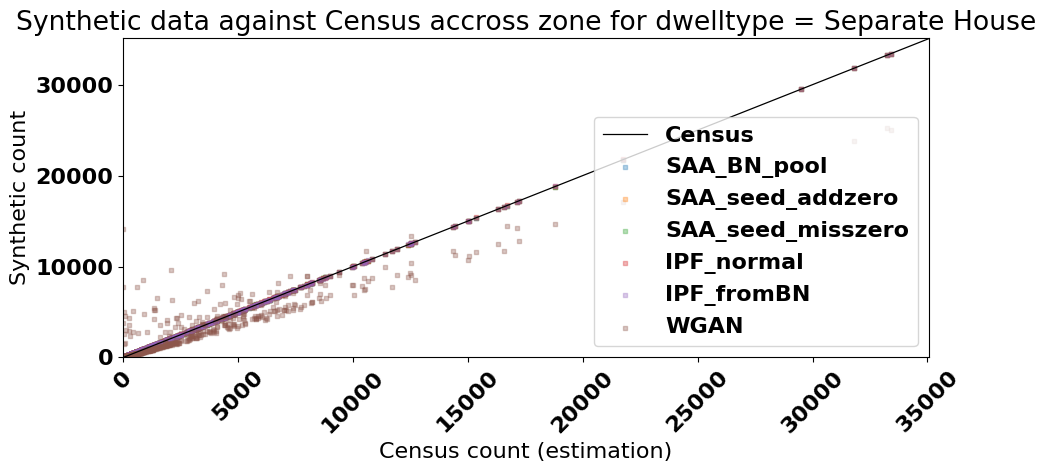

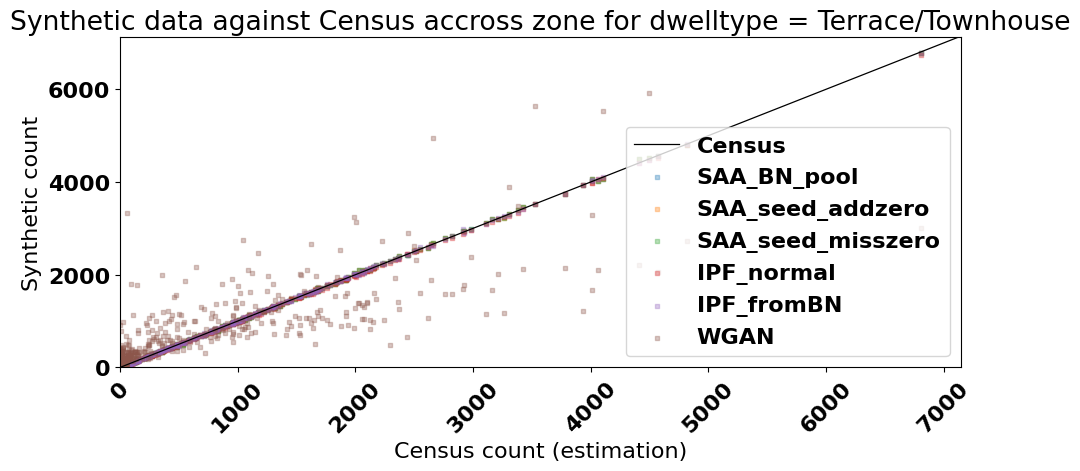

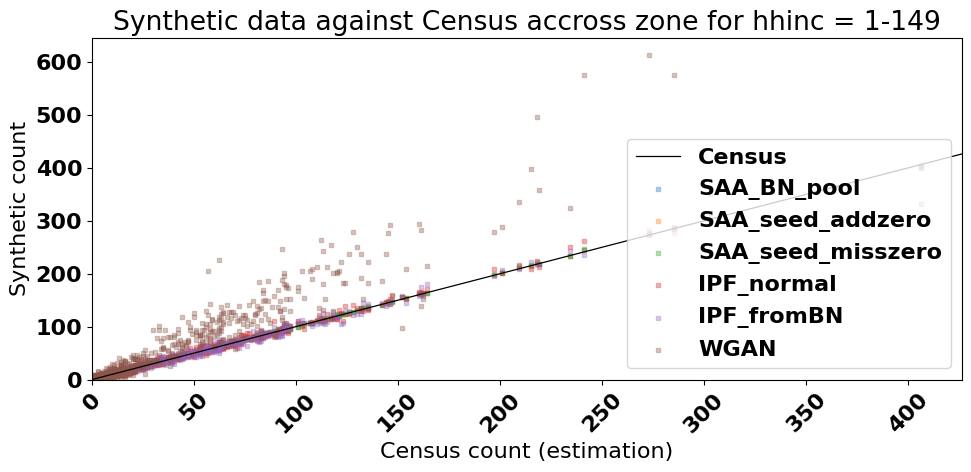

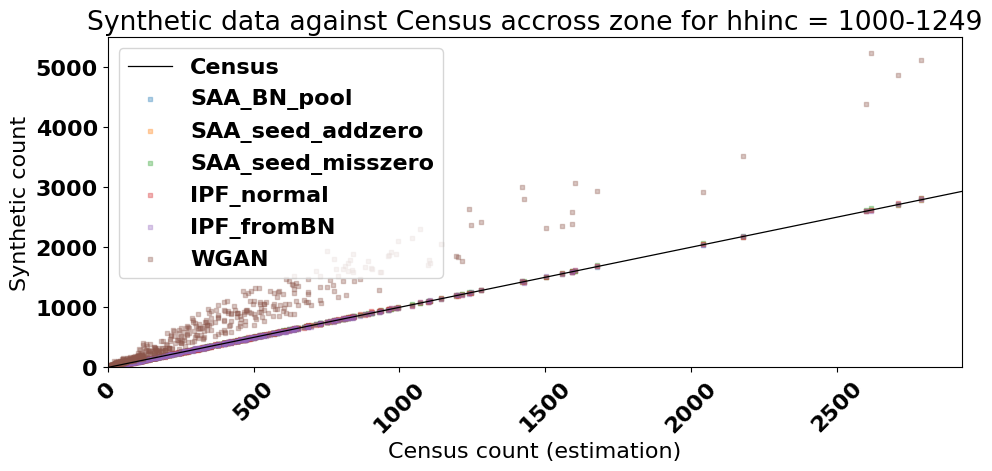

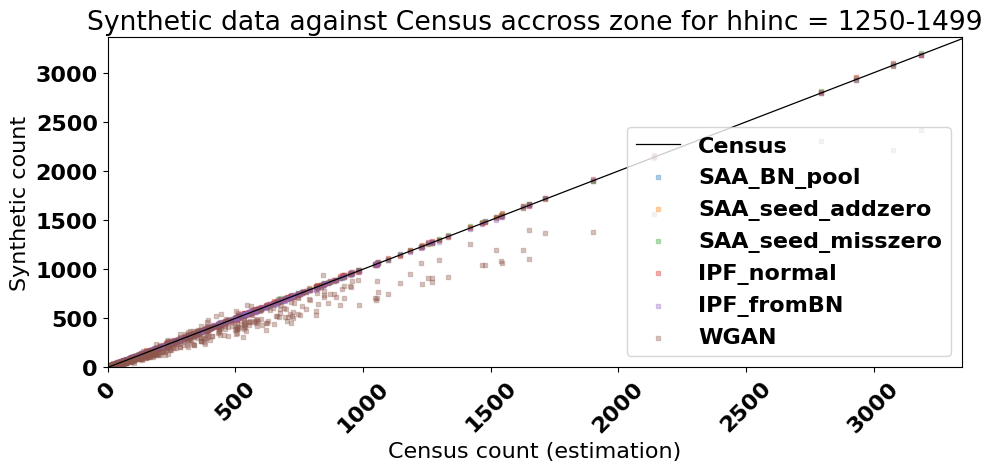

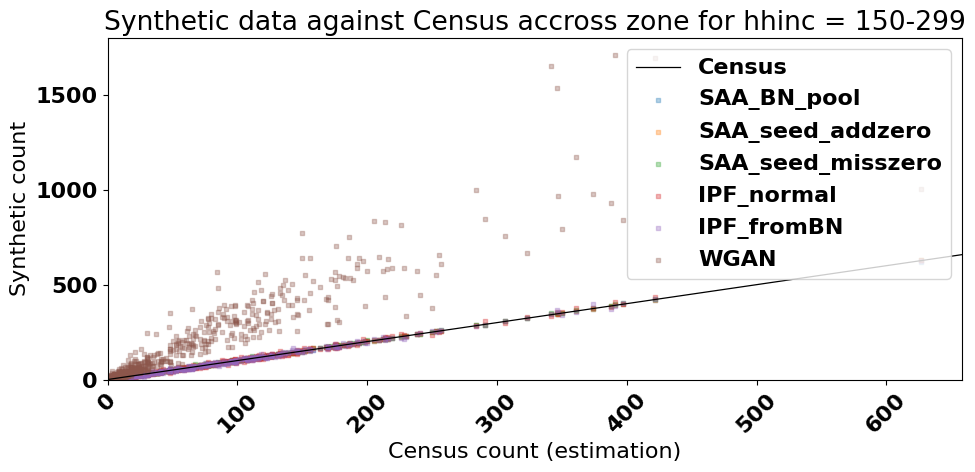

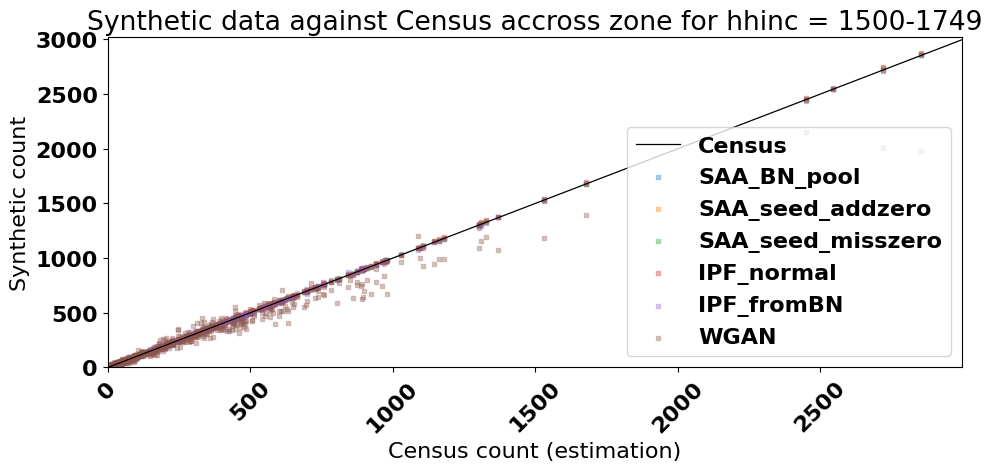

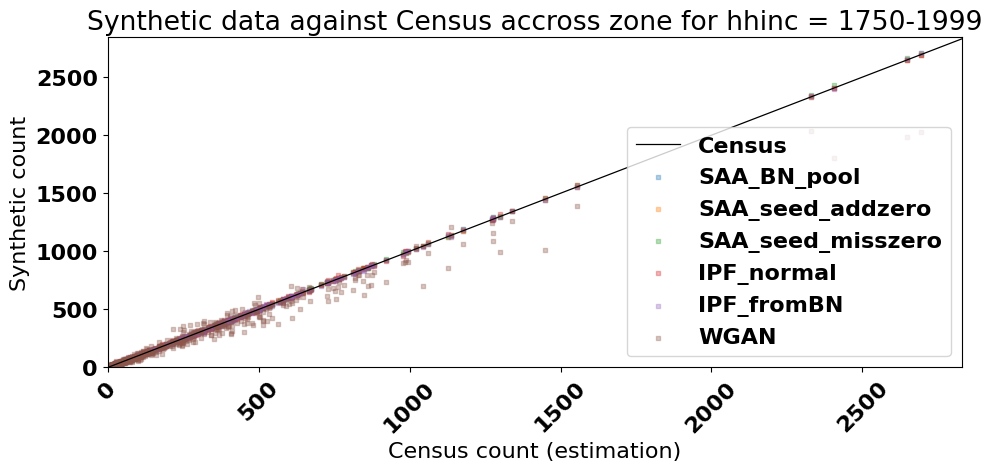

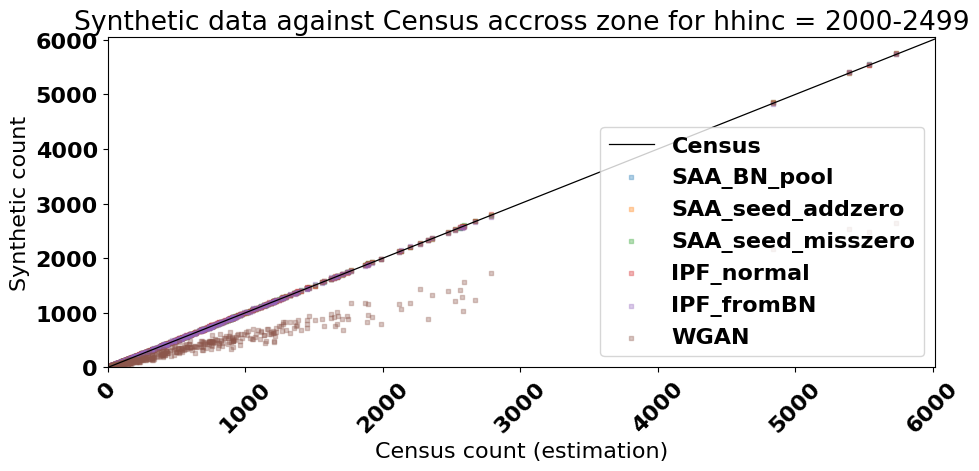

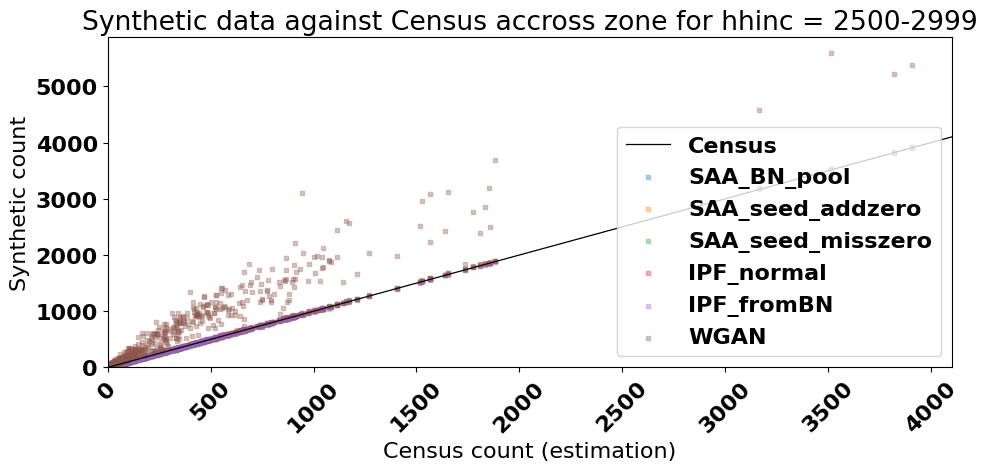

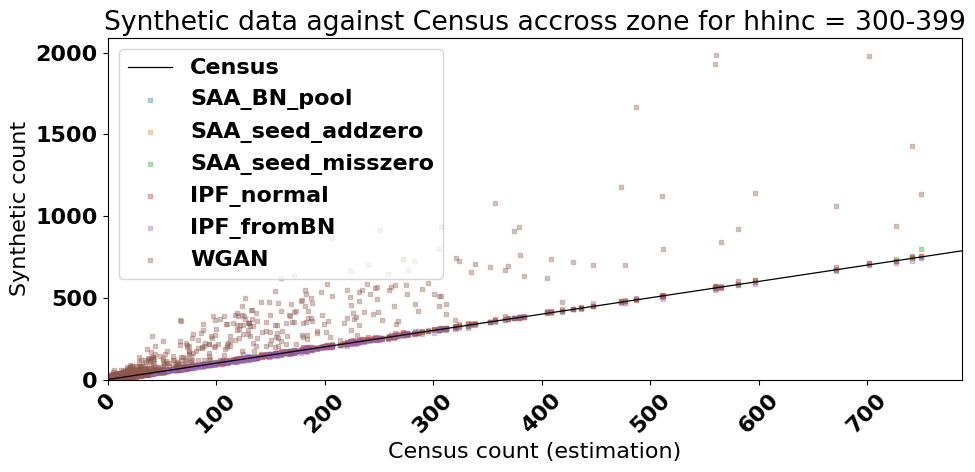

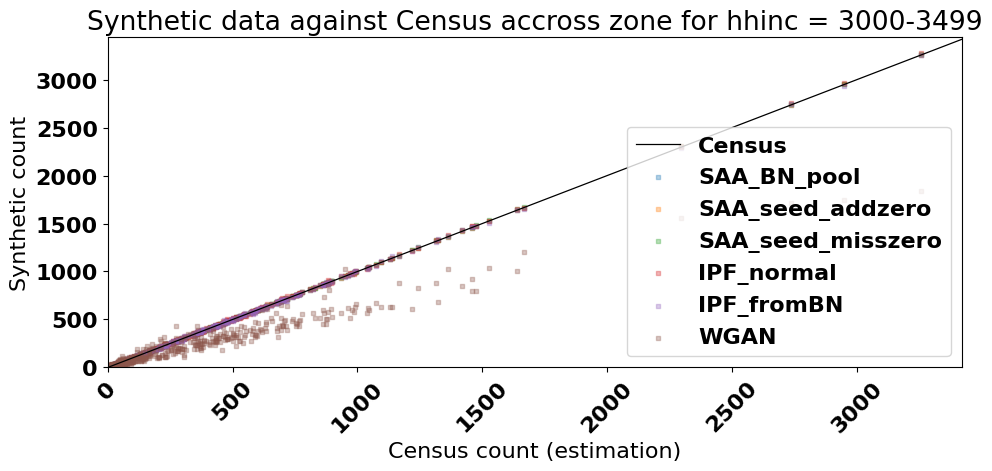

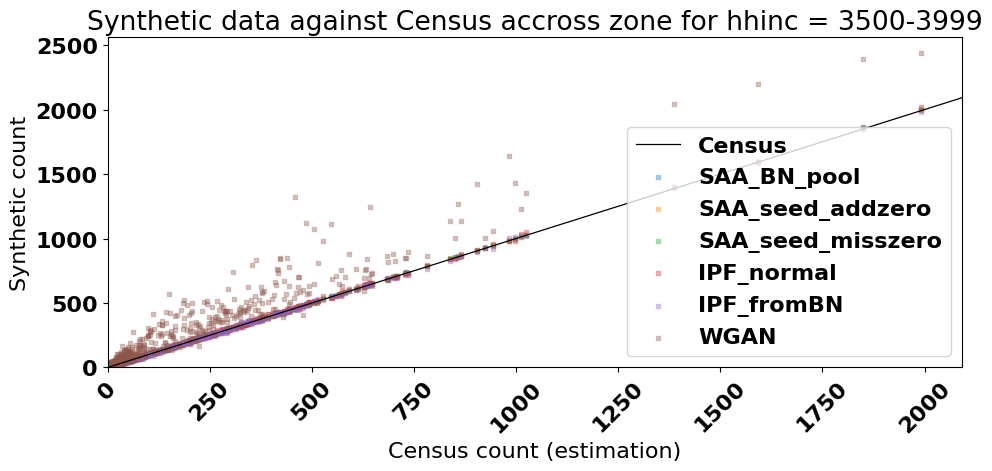

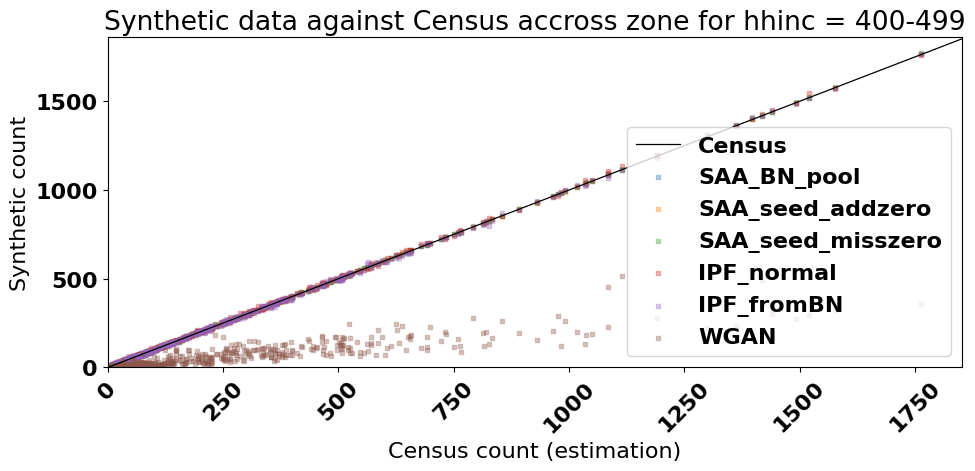

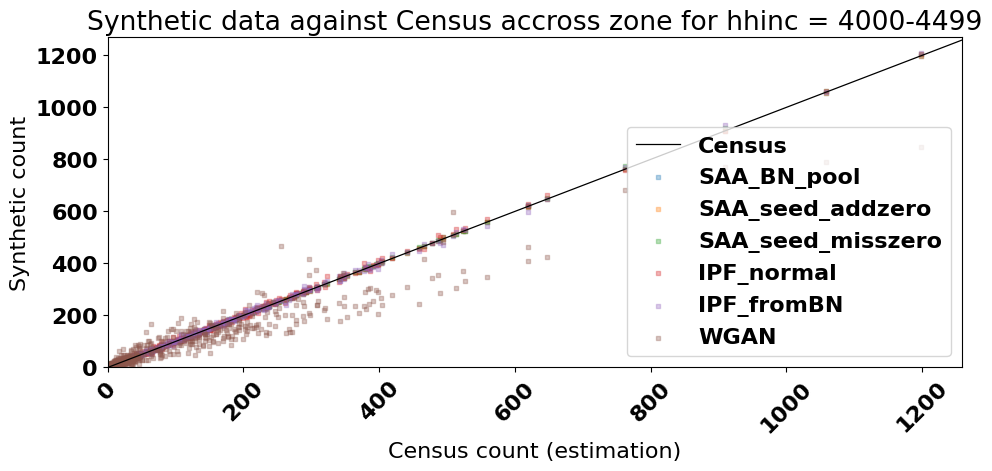

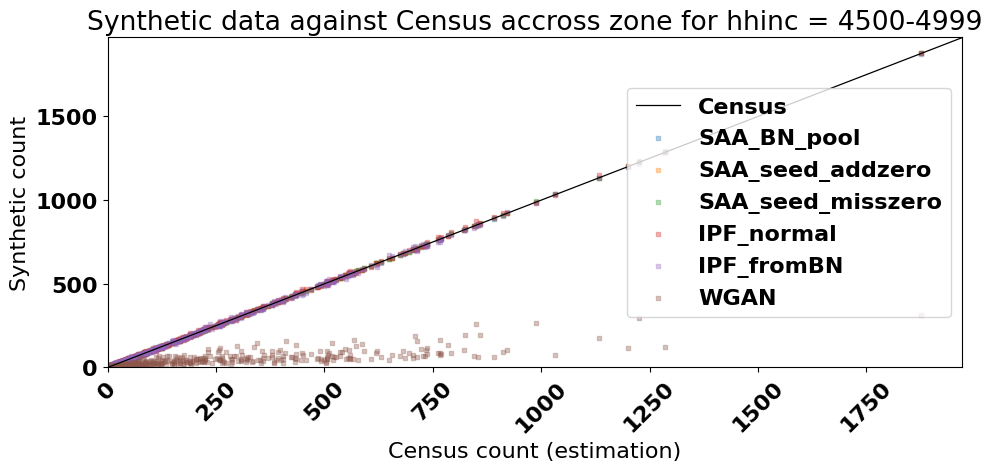

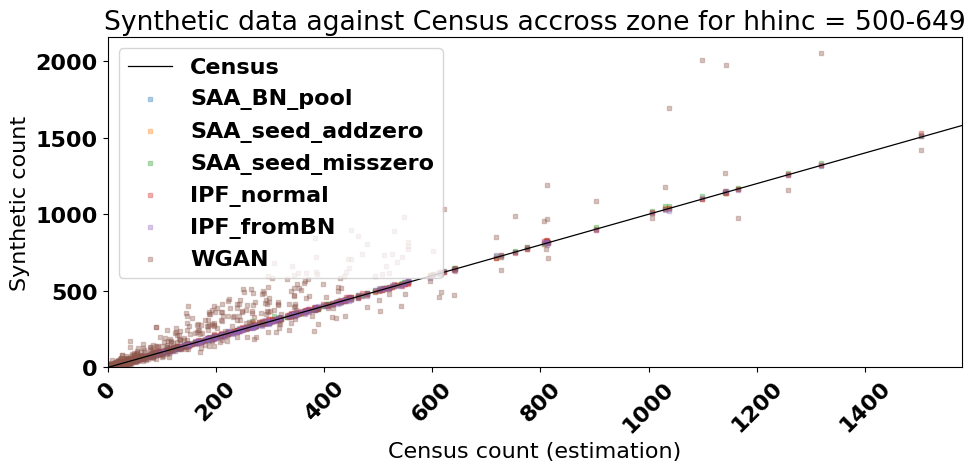

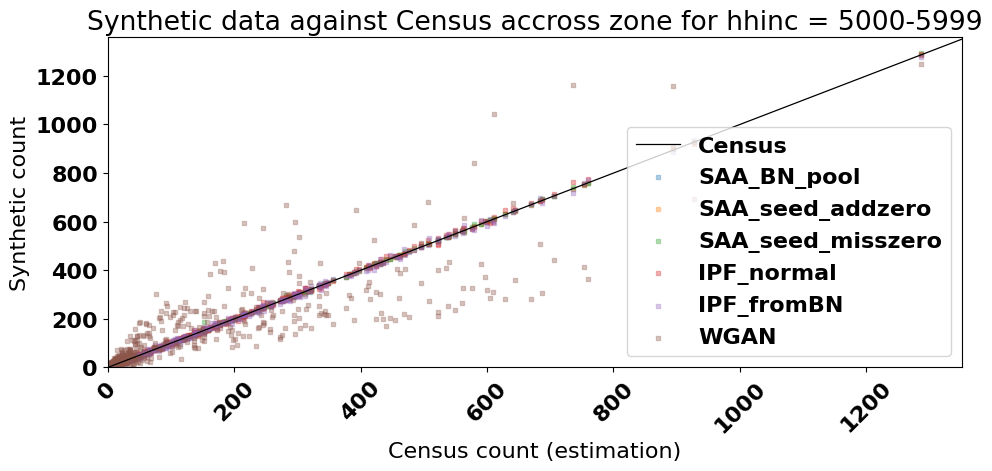

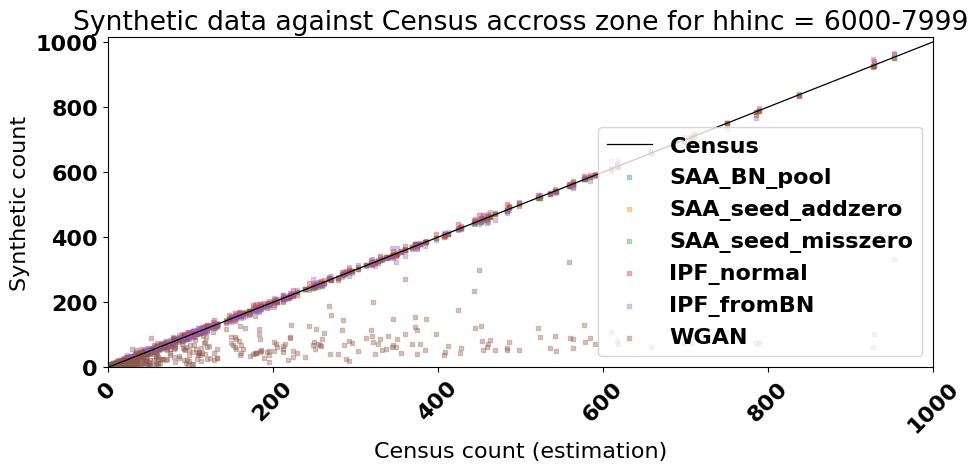

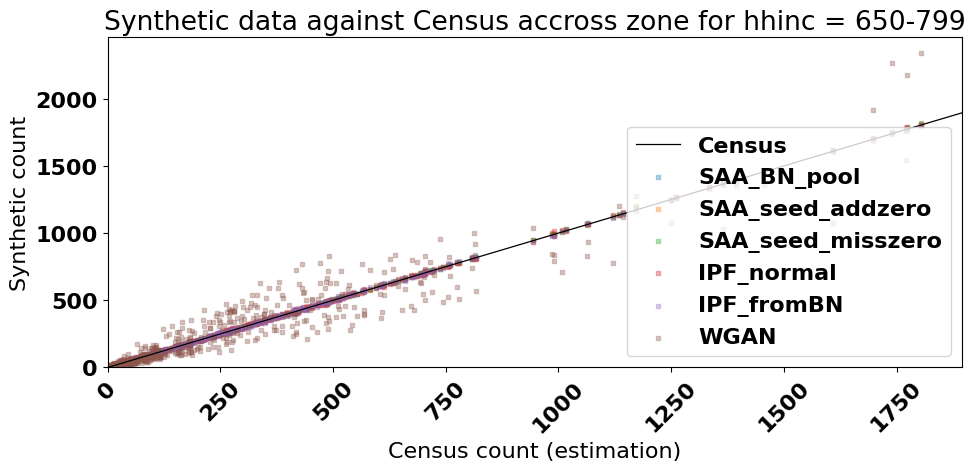

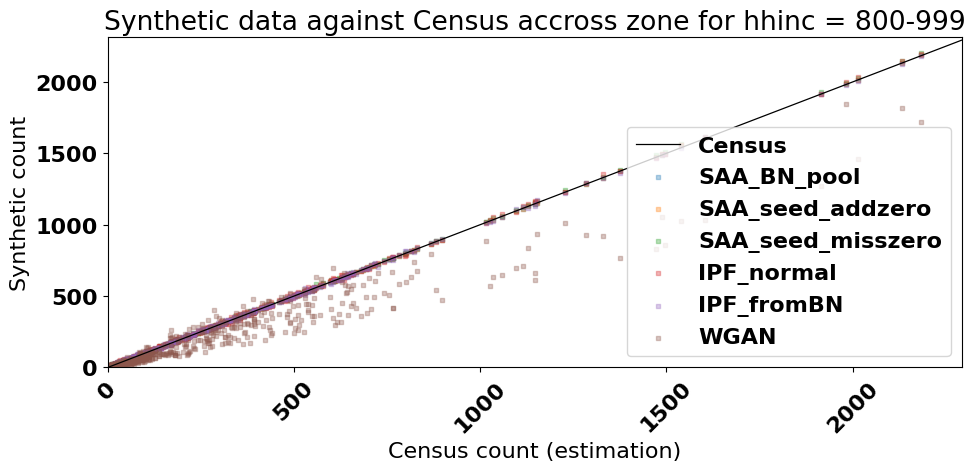

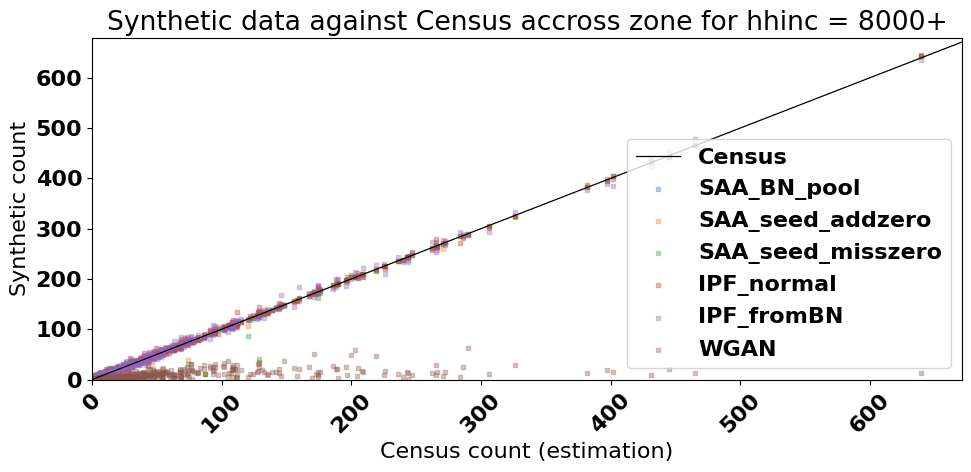

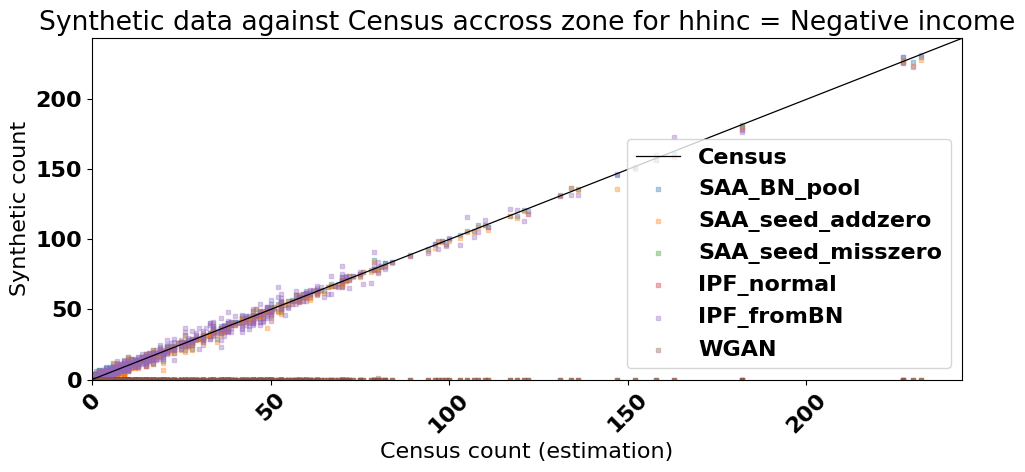

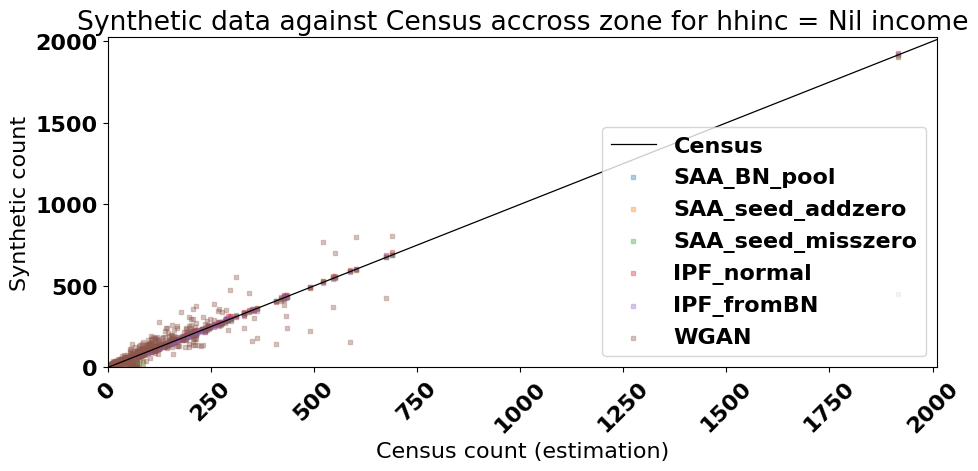

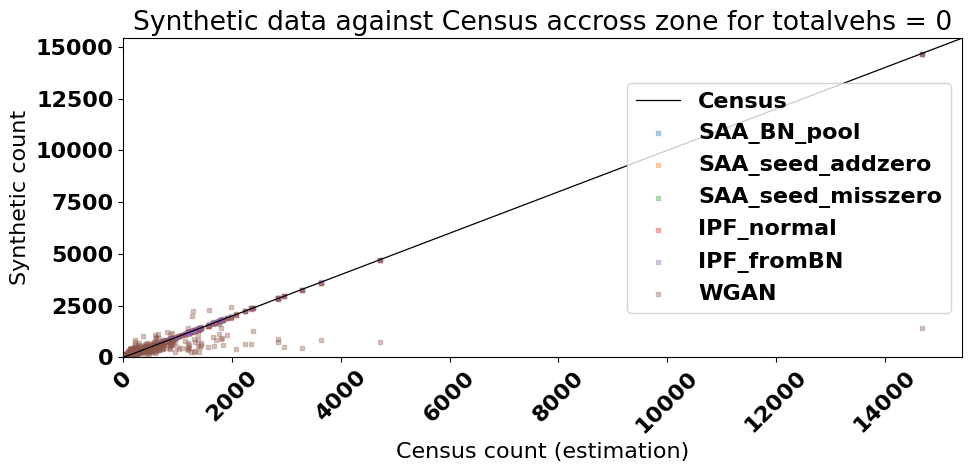

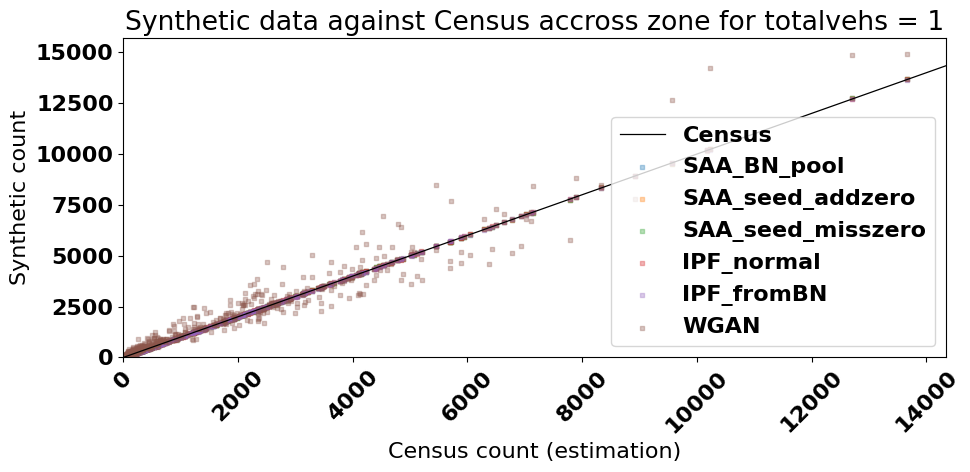

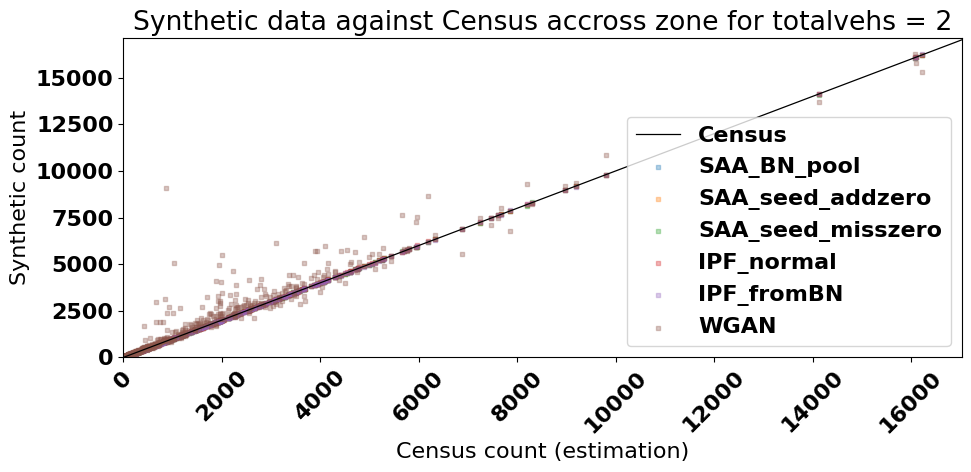

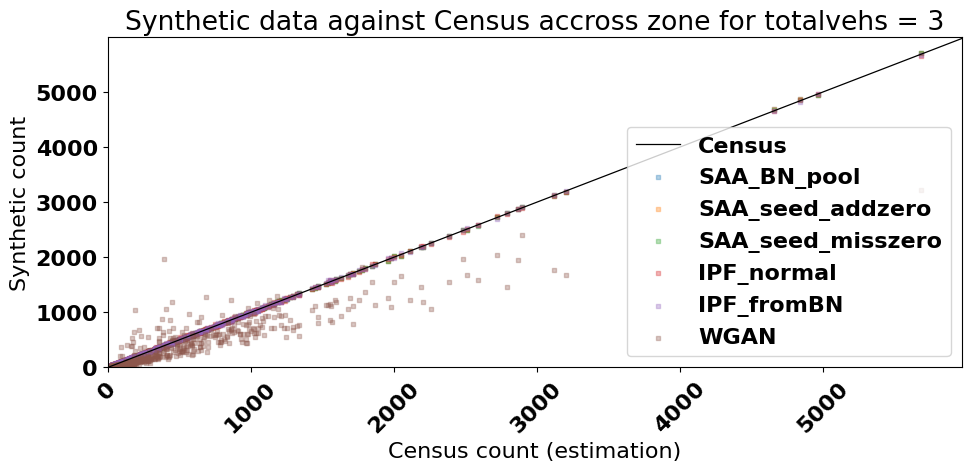

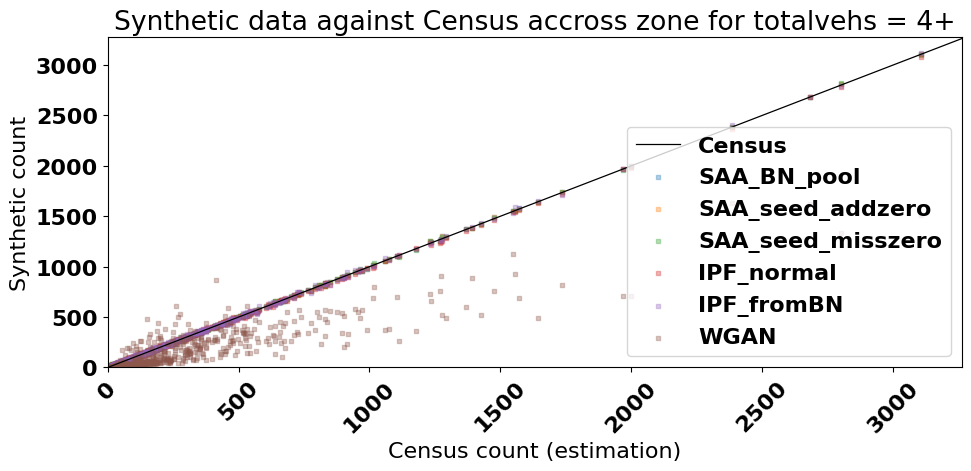

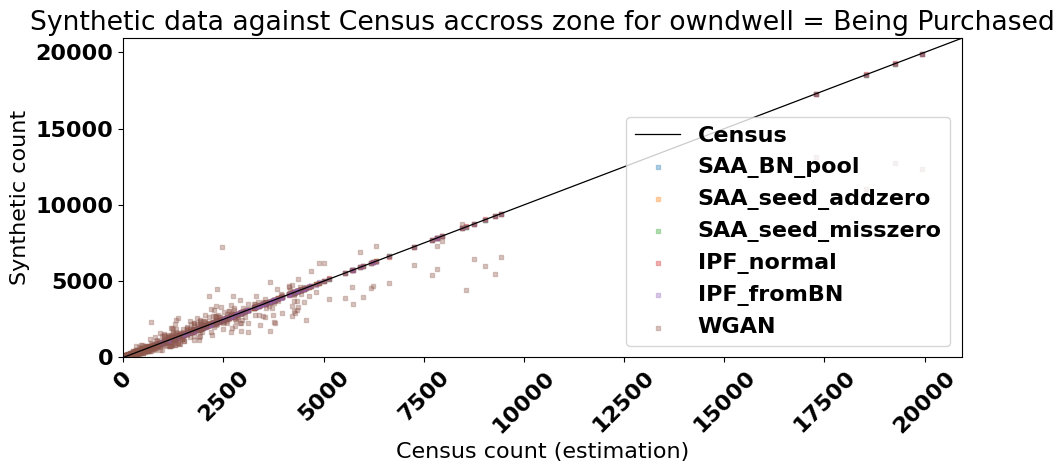

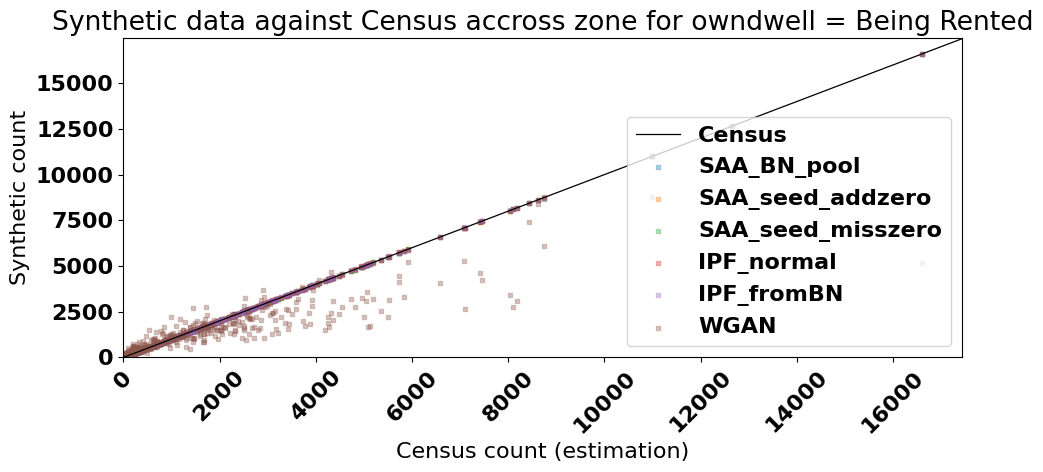

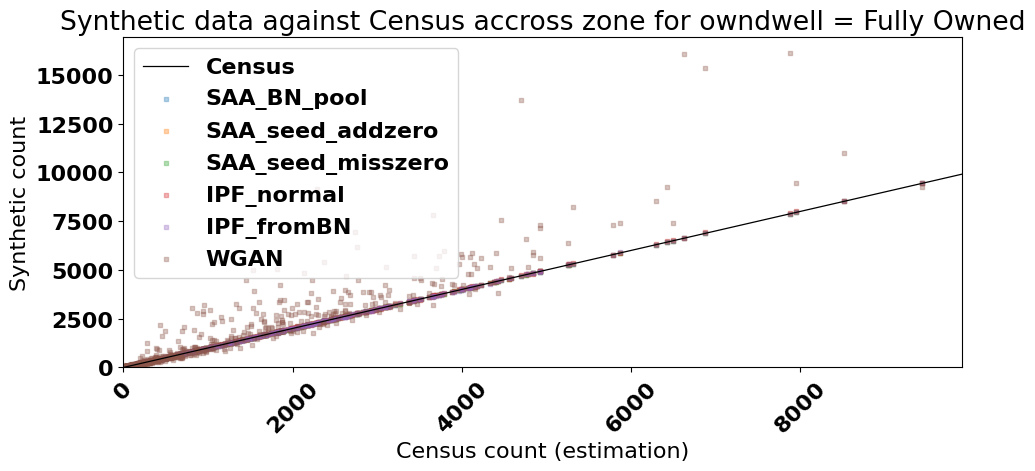

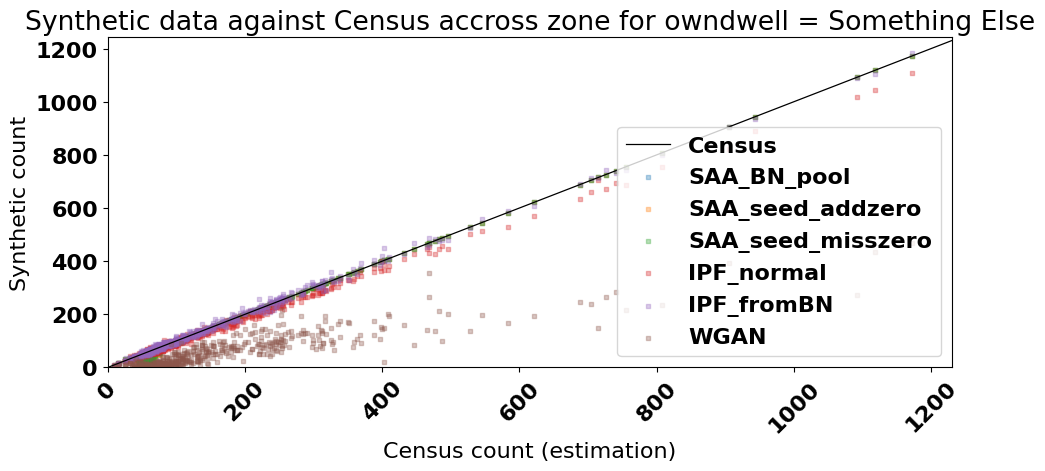

In [10]:
for state in census_data.columns:
    x = census_data[state].values
    fig = plt.figure(figsize = (10, 5))
    ax1 = fig.add_subplot(111)
    ax1.axline((0, 0), slope=1, c="black", linewidth=0.9, label="Census")
    for name, data in marg_formatted_data.items():
        y = data[state].values
        ax1.scatter(x, y, s=10, marker="s", label=name, alpha=0.33)

    plt.xlabel(f"Census count (estimation)")
    plt.ylabel("Synthetic count")
    plt.title(f"Synthetic data against Census accross zone for {state[0]} = {state[1]}")
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Calculate RMSE

In [11]:
powered2_diff_marg = {name: (census_data - df).pow(2) for name, df in marg_formatted_data.items()}

### By zonal

In [12]:
zonal_RMSE = {name: df.mean(axis=1).apply(np.sqrt) for name, df in powered2_diff_marg.items()}

In [13]:
poa_geo = gpd.read_file(os.path.join(folder_loc,f"POA_2021_AUST_GDA2020_SHP.zip"), columns=["POA_CODE21"], engine="pyogrio")
poa_geo["POA"] = poa_geo["POA_CODE21"].astype(str)
poa_geo = poa_geo.set_index("POA").drop(columns=["POA_CODE21"])

ls_metro_mel_raw = [
    (3000, 3211),
    (3335, 3336),
    (3338, 3338),
    (3427, 3429),
    (3750, 3752),
    (3754, 3755),
    (3759, 3761),
    (3765, 3775),
    (3781, 3787),
    (3788, 3815),
    (3910, 3920),
    (3926, 3944),
    (3975, 3978),
    (3980, 3980)
]
ls_metro_poa_all = []
for pair_range in ls_metro_mel_raw:
    ls_metro_poa_all += list(range(pair_range[0], pair_range[1]+1))
ls_metro_poa_all = [str(x) for x in ls_metro_poa_all]

In [14]:
def get_zonal_results(RMSE_by_zone, geo_file, ls_sub_zones=None, all_name="HH"):
    new_rmse_col = "RMSE"
    for name, RMSE_df in RMSE_by_zone.items():
        geo_file = geo_file[geo_file.index.isin(RMSE_df.index)]
        geo_file.loc[RMSE_df.index, new_rmse_col] = RMSE_df

        if ls_sub_zones is None:
            fin_sub_zones = None
        else:
            fin_sub_zones = geo_file[geo_file.index.isin(ls_sub_zones)]
        
        if all_name == "HH":
            vmax = 50
        else:
            vmax = 10000

        ax_all = geo_file.plot(column=new_rmse_col, legend=True, figsize=(20, 12), vmin=0, vmax=vmax, cmap="plasma")
        ax_all.set_title(f"All_VIC - {all_name}_RMSE_{name}")
        # plt.savefig(f'./output/imgs/{all_name}_All_{geo_lev}_{method}_RMSE.png',bbox_inches='tight')
        if fin_sub_zones is not None:
            ax_sub = fin_sub_zones.plot(column=new_rmse_col, legend=True, figsize=(20, 12), vmin=0, vmax=vmax, cmap="plasma")
            ax_sub.set_title(f"Metro_VIC - {all_name}_RMSE_{name}")
            # plt.savefig(f'./output/imgs/{all_name}_Metro_{geo_lev}_{method}_RMSE.png',bbox_inches='tight')

c:\Users\dlaa0001\Anaconda3\envs\popsyn\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


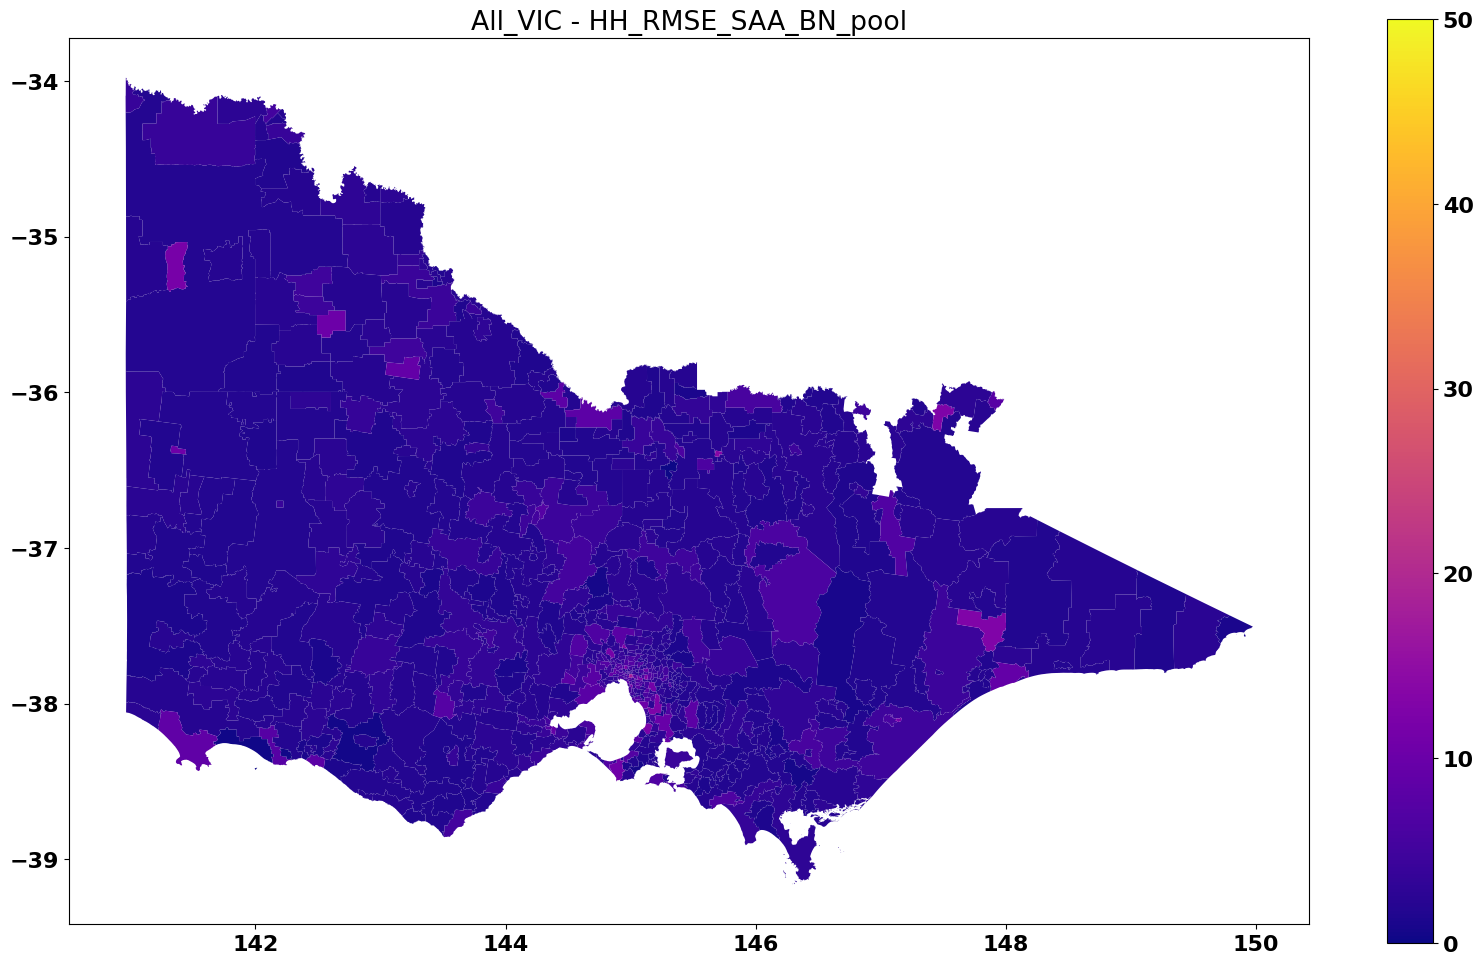

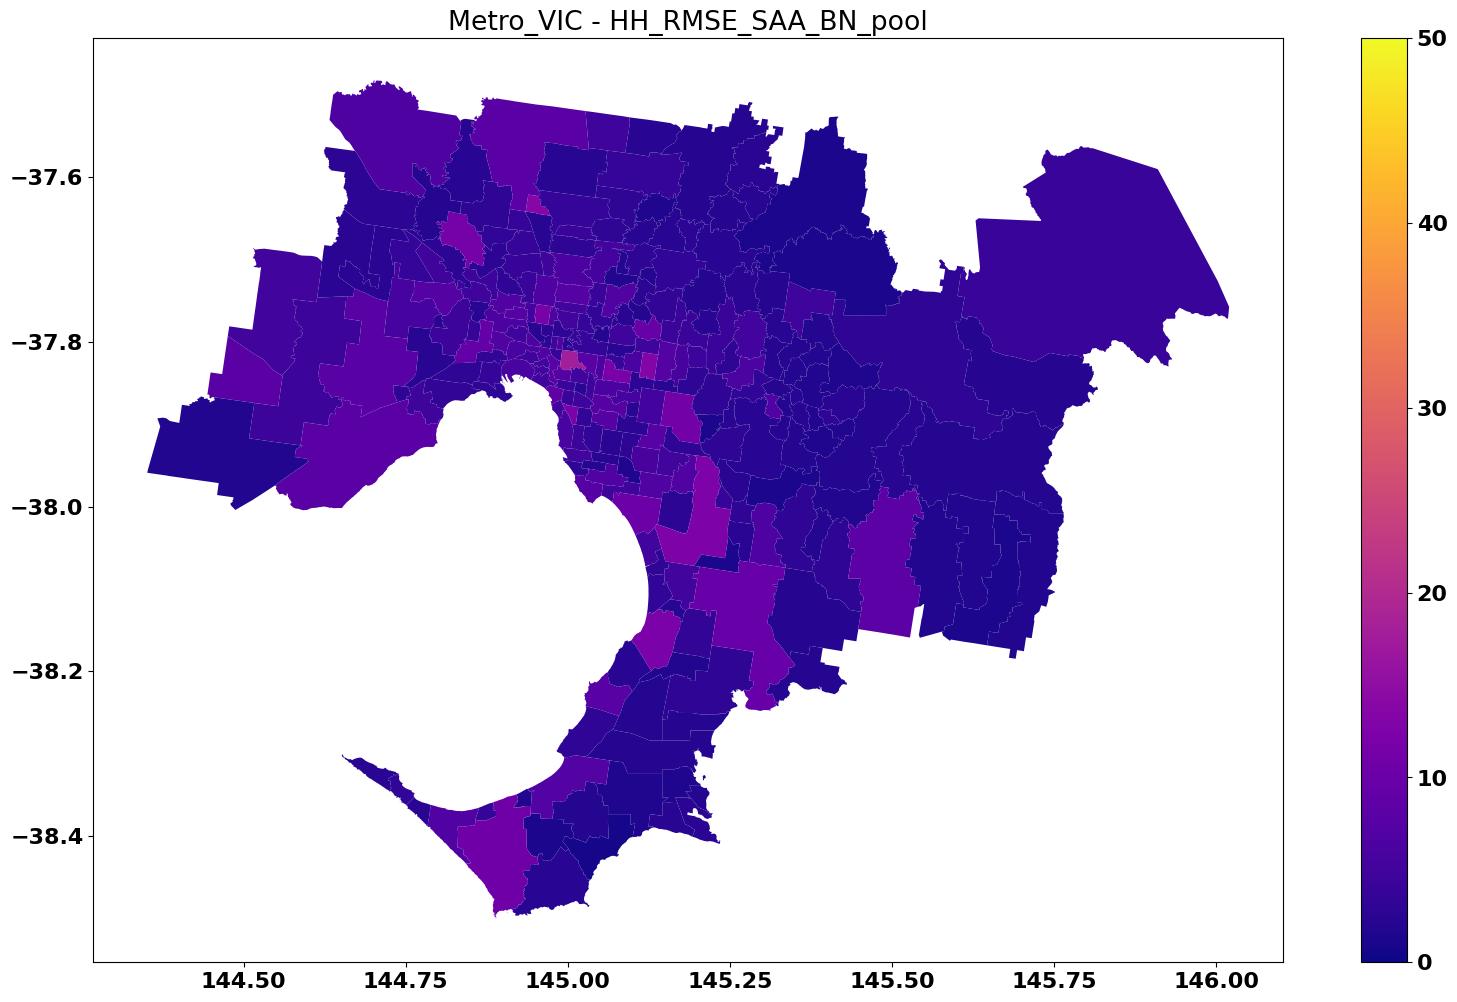

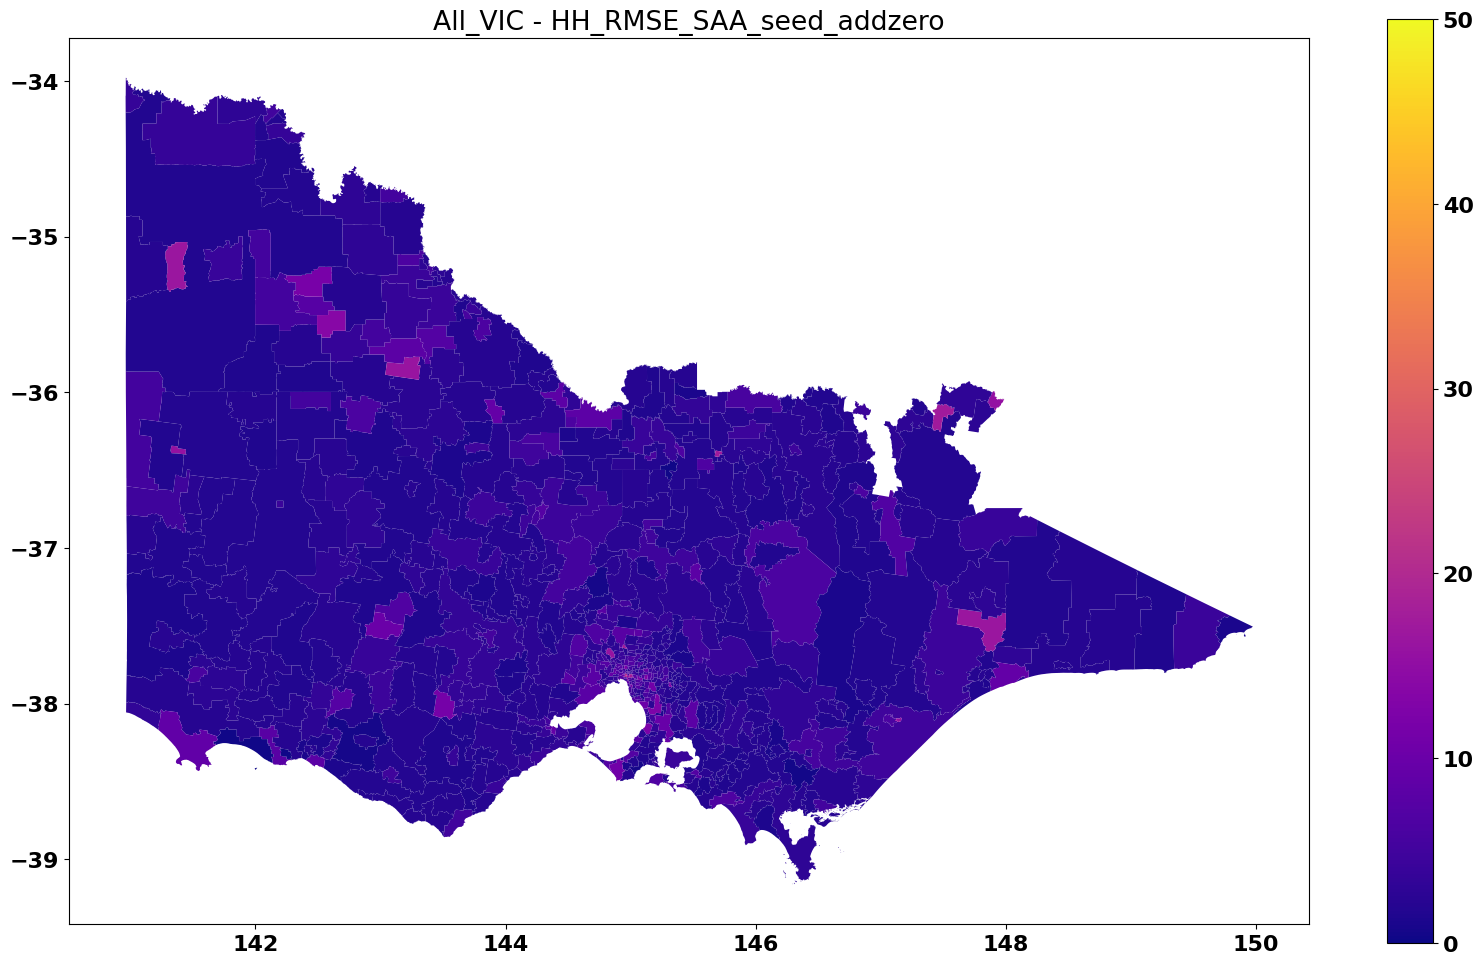

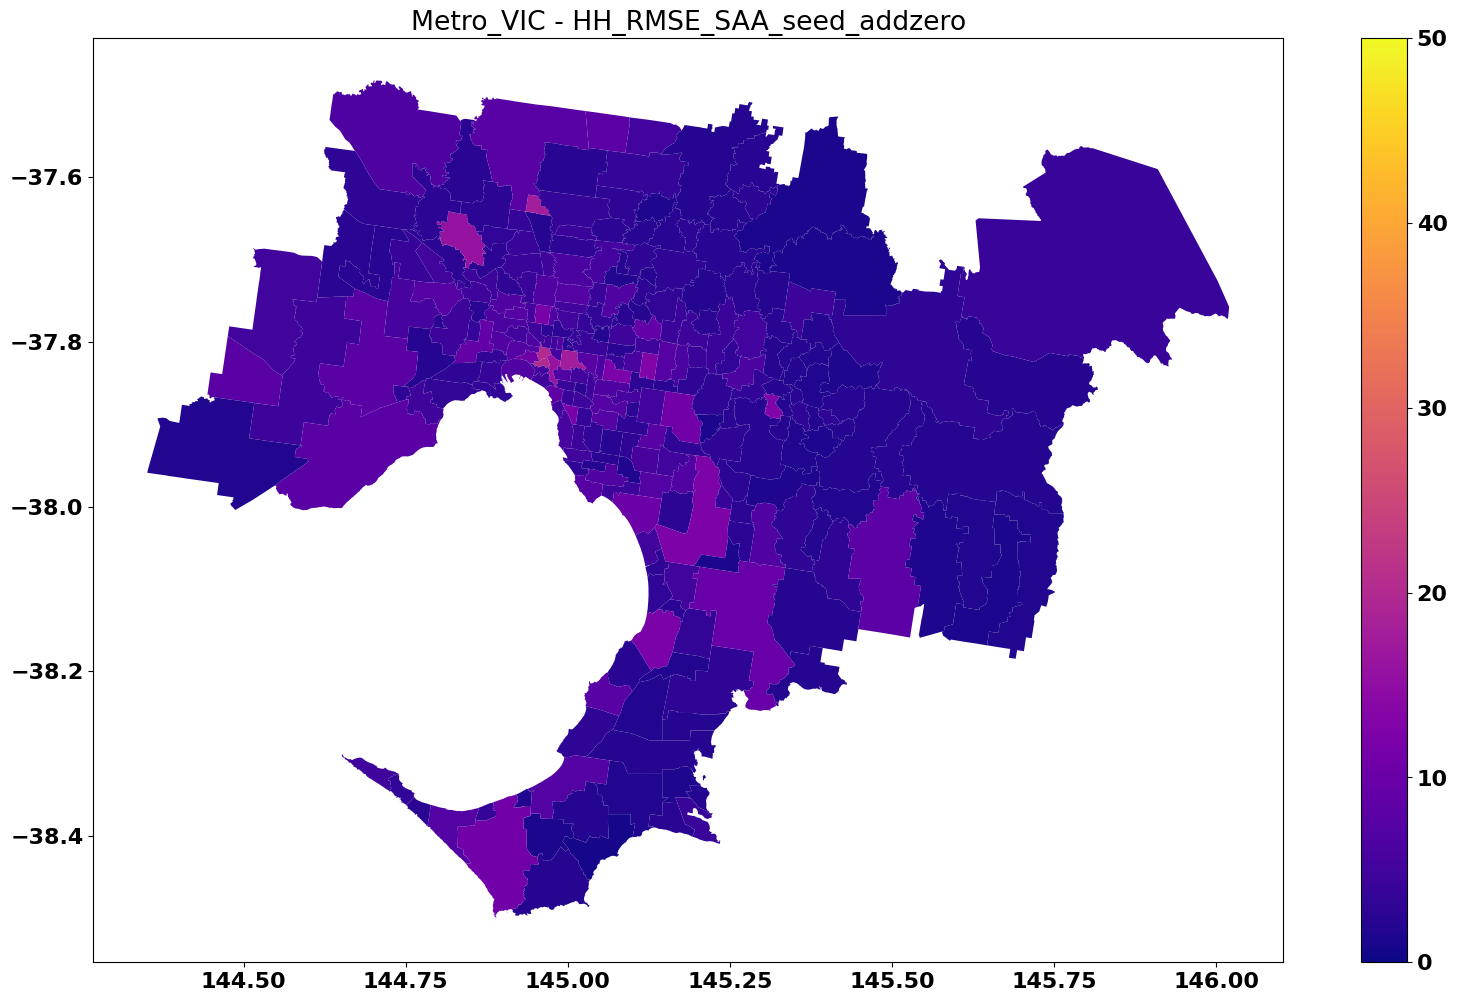

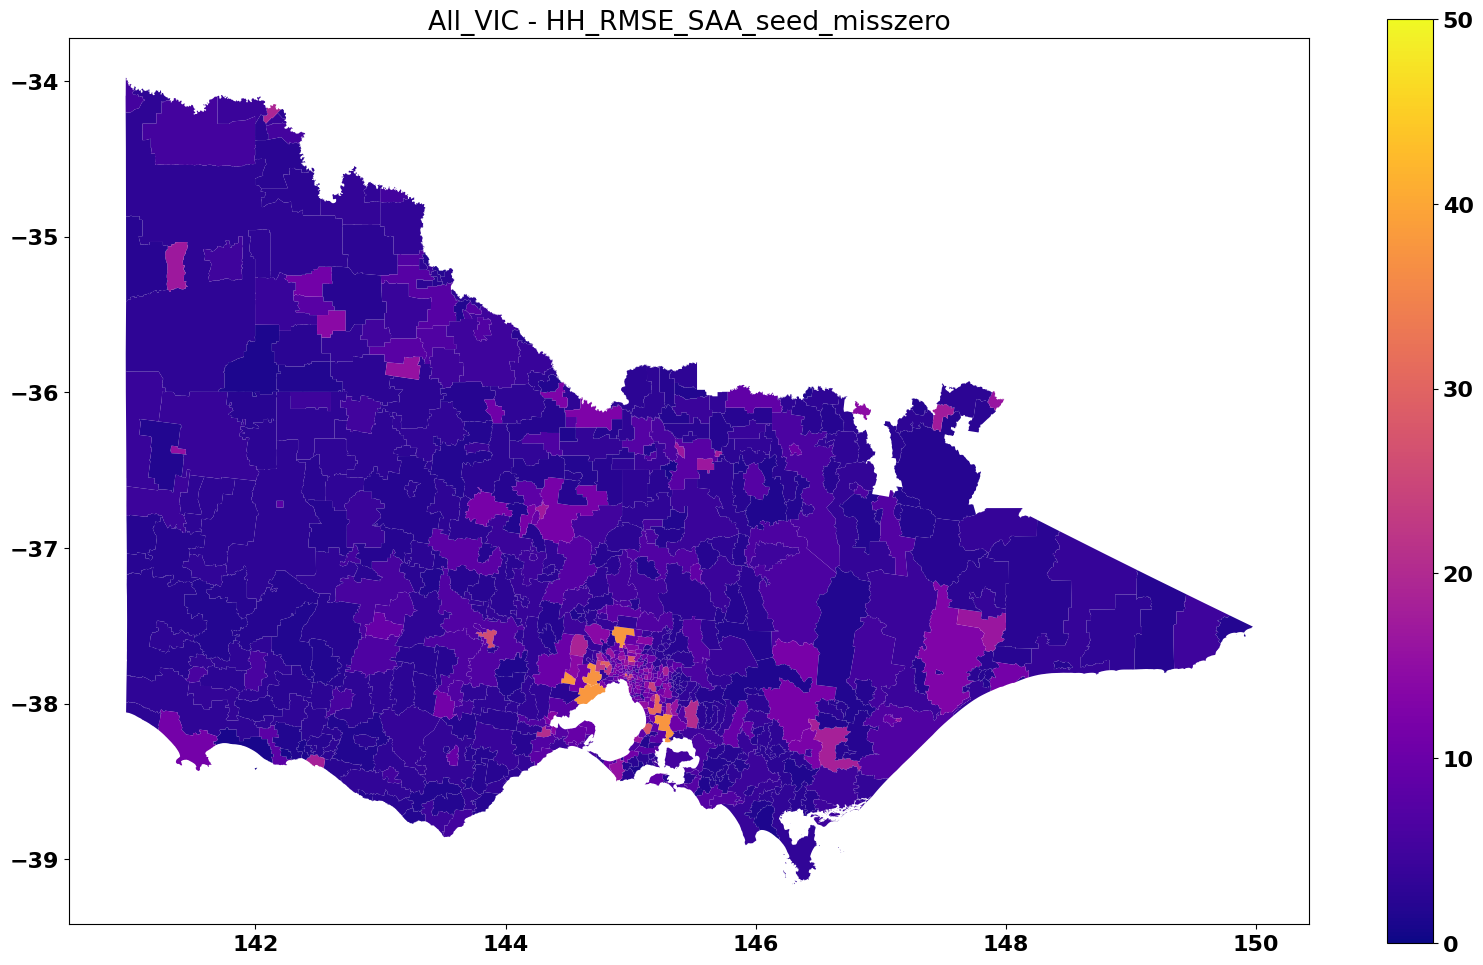

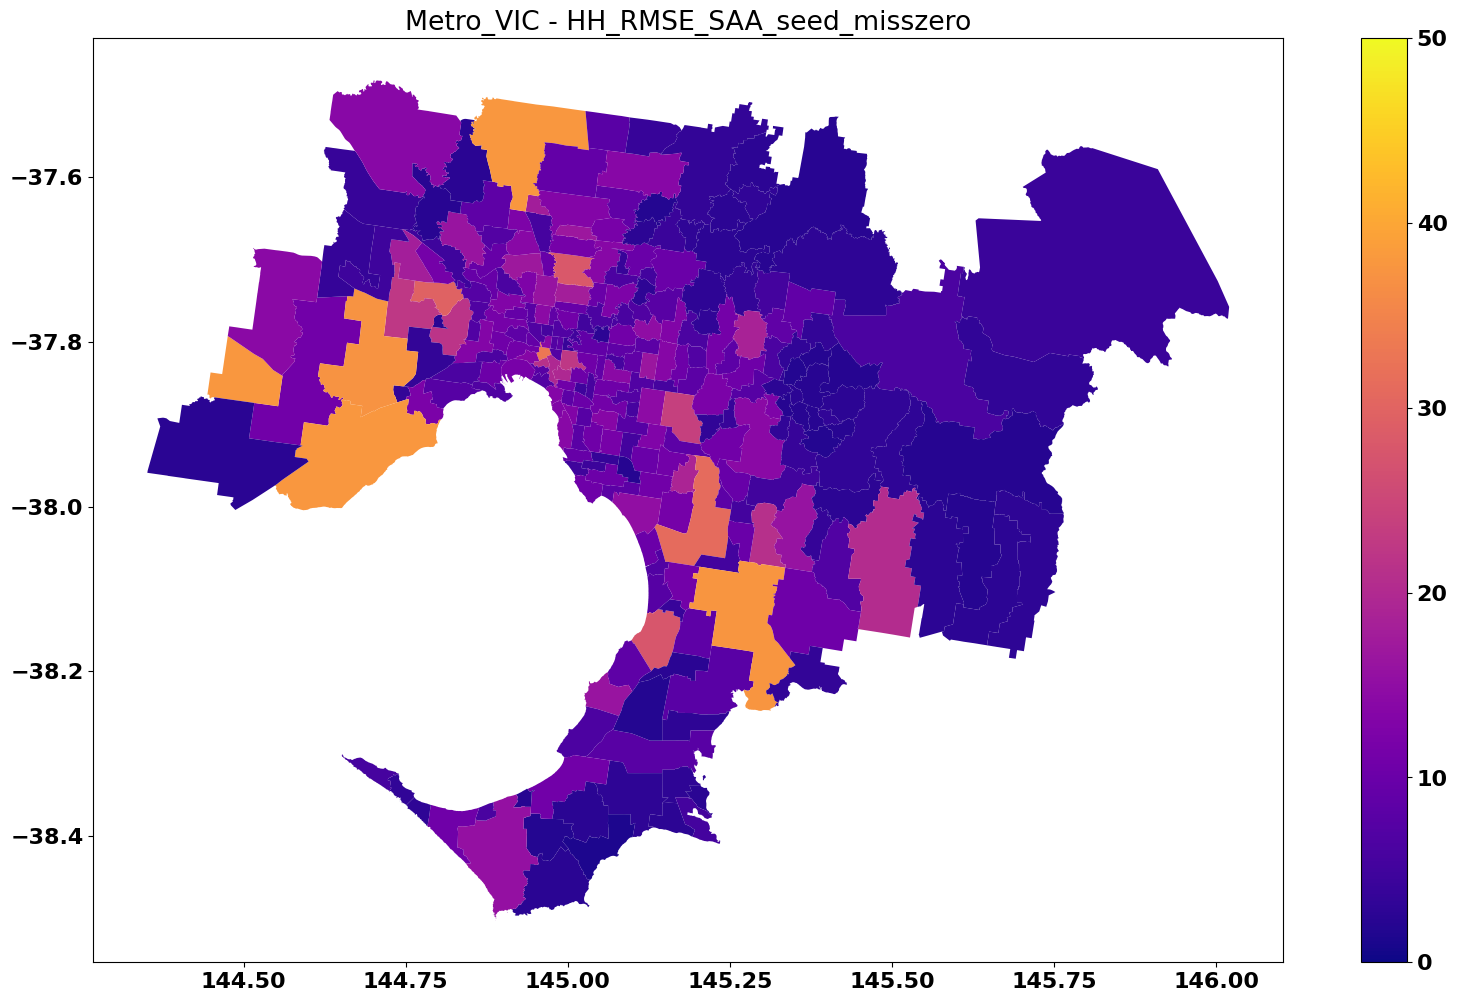

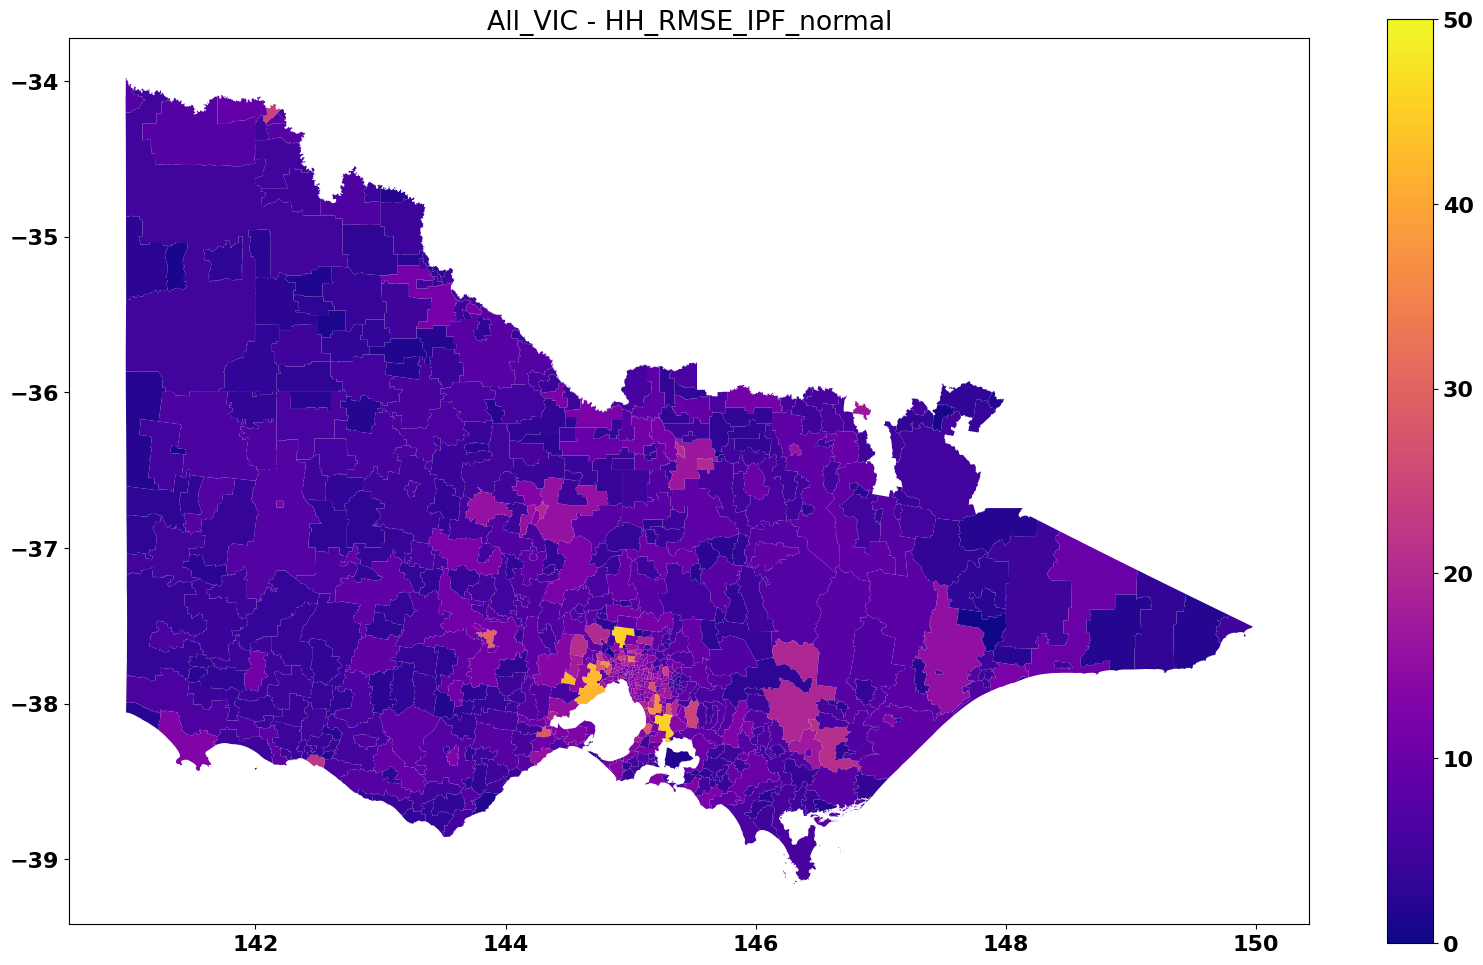

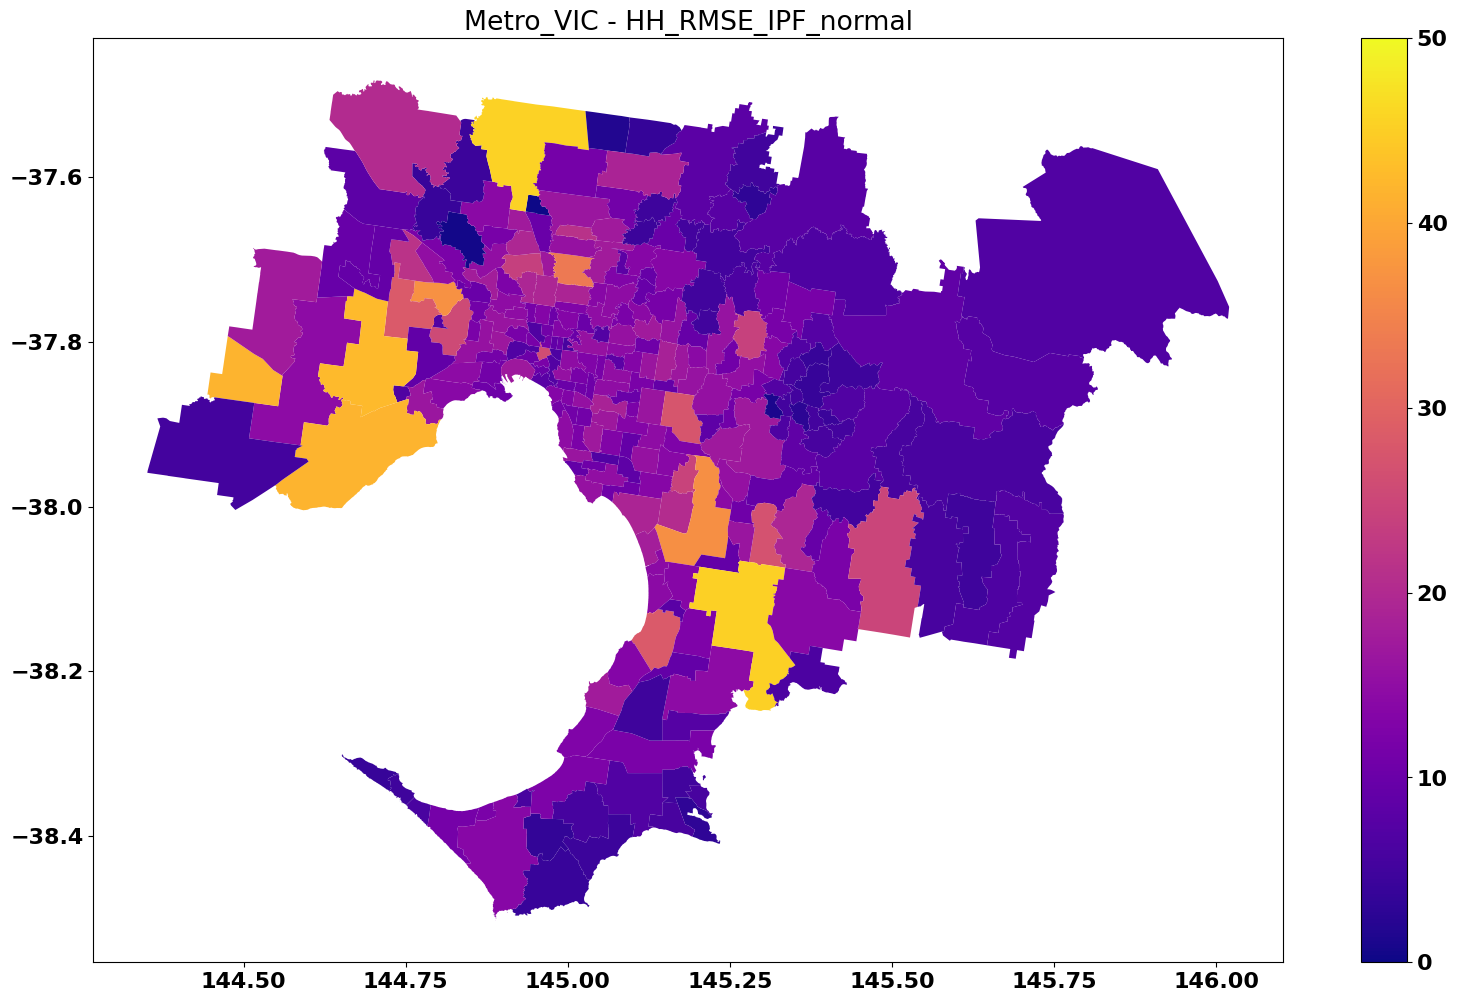

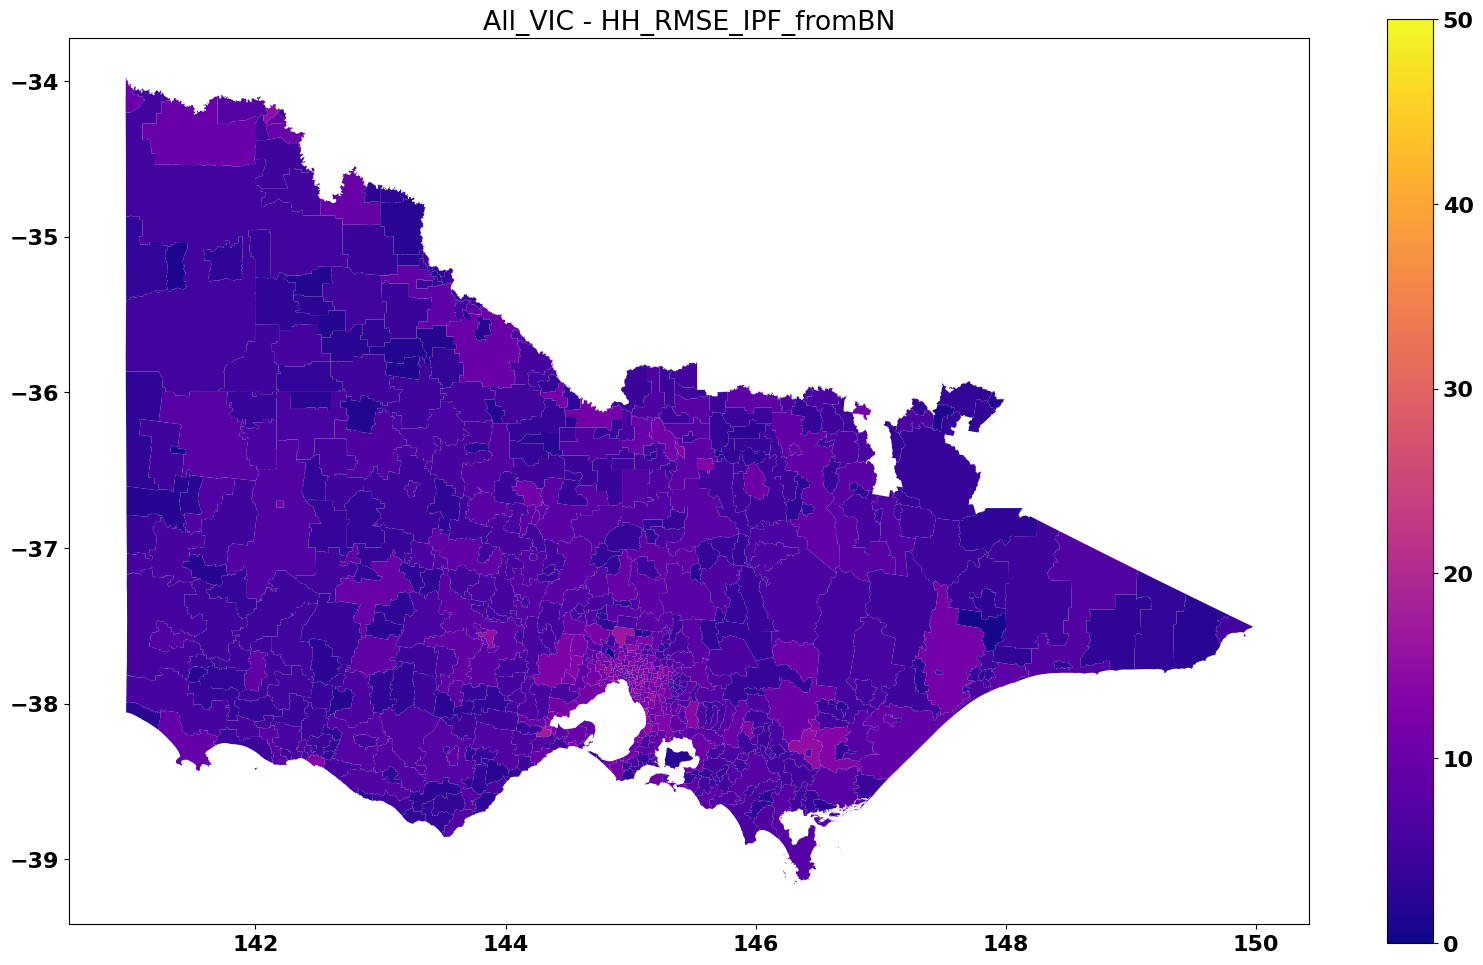

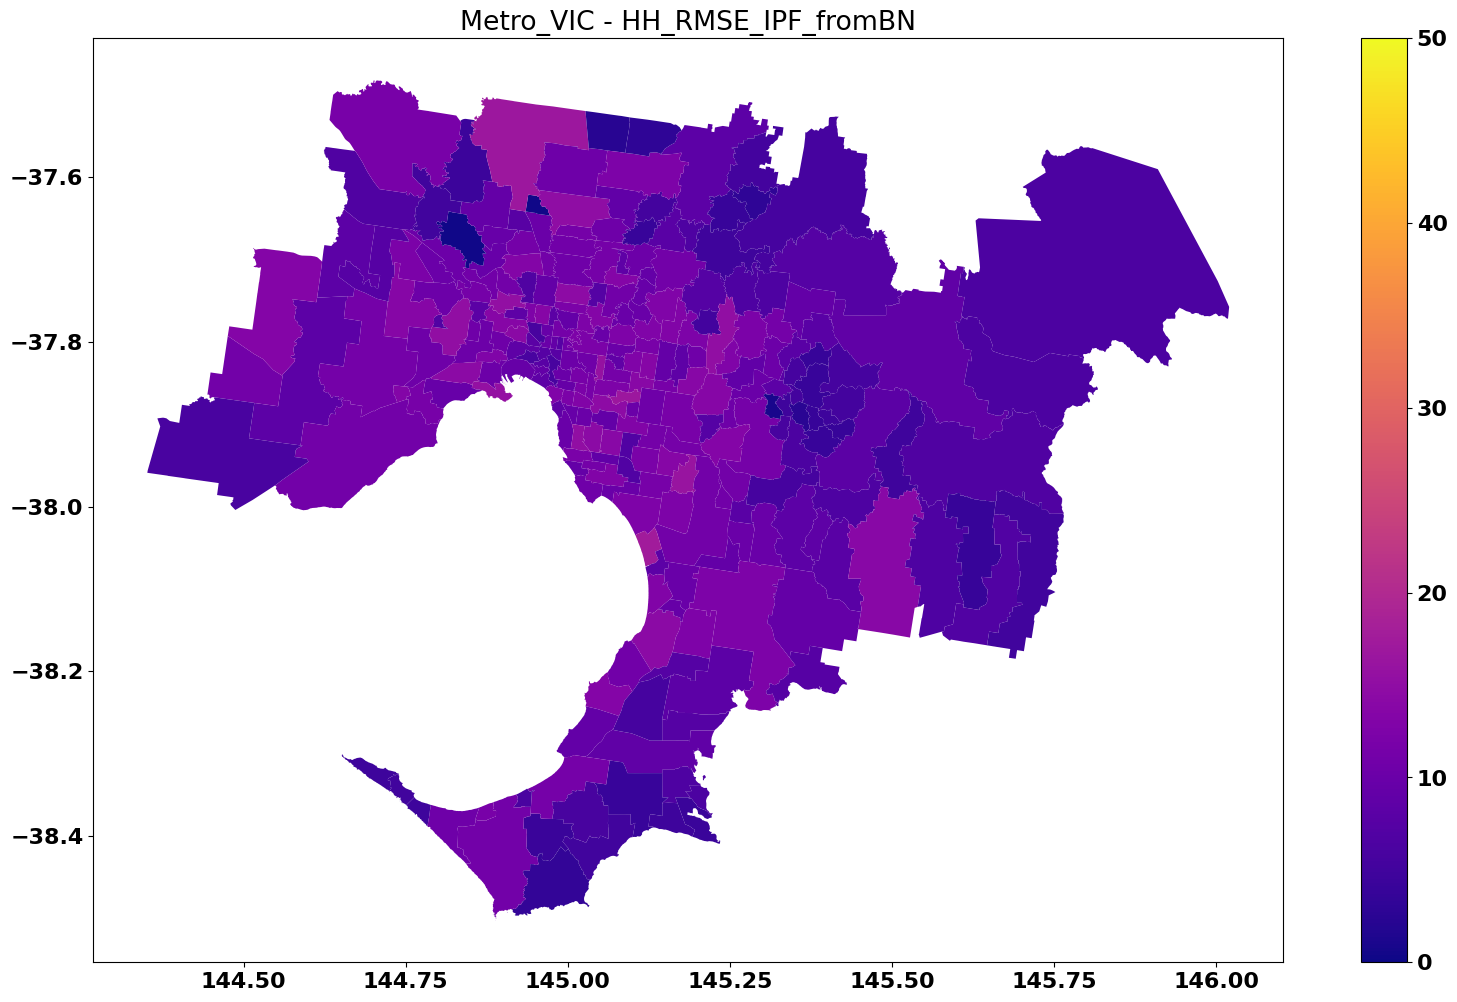

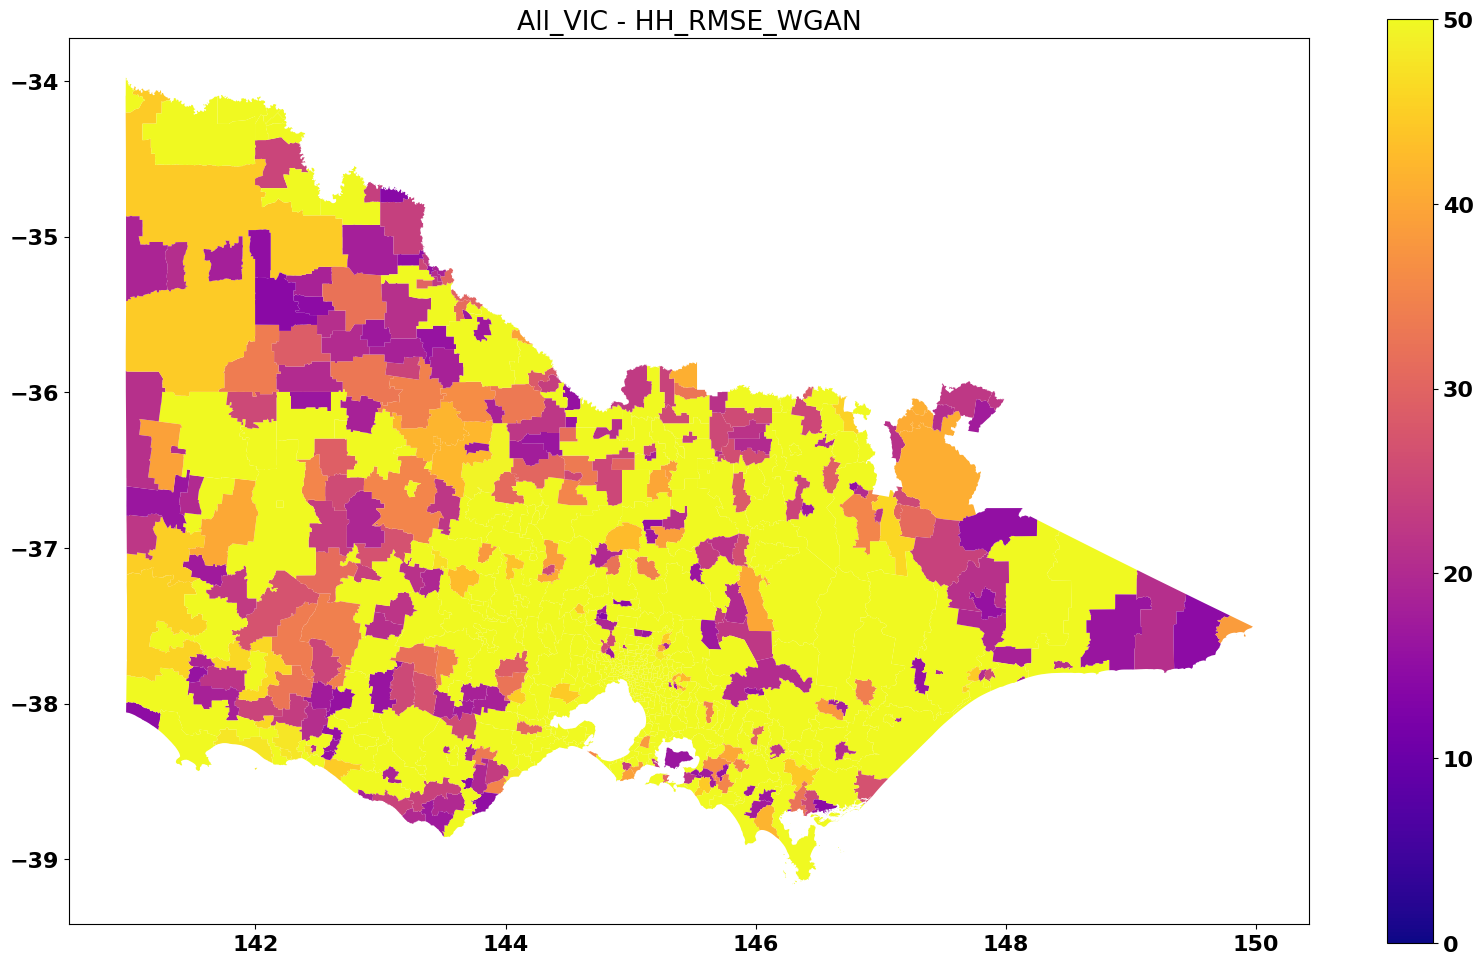

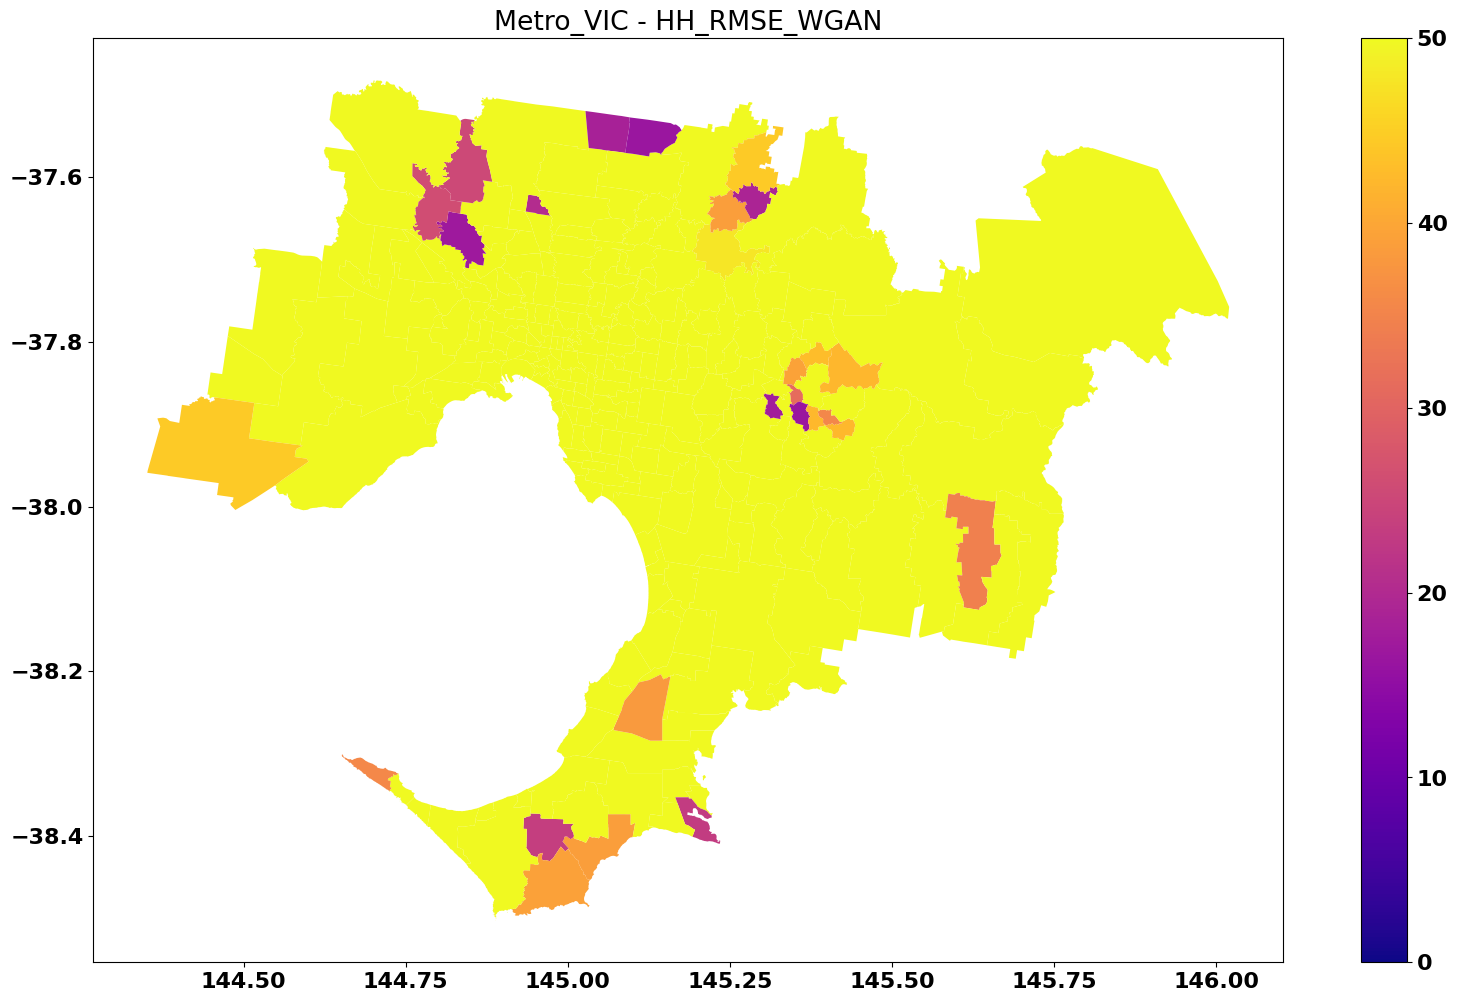

In [15]:
get_zonal_results(zonal_RMSE, poa_geo, ls_metro_poa_all, "HH")

### By atts

In [16]:
atts_RMSE = {name: df.mean(axis=0).apply(np.sqrt) for name, df in powered2_diff_marg.items()}

In [17]:
converted_atts_rmse = pd.DataFrame(atts_RMSE)
converted_atts_rmse.index.set_names(["Attribute", "State"], inplace=True)
fin_atts_rmse = converted_atts_rmse.reset_index()
fin_atts_rmse = fin_atts_rmse.drop(columns=["State"]).groupby("Attribute").mean()
fin_atts_rmse

SAA_BN_pool  SAA_seed_addzero  SAA_seed_misszero  IPF_normal  \
Attribute                                                                 
dwelltype     7.047321          7.817347           7.999513    8.583423   
hhinc         2.128185          2.684974           5.504256    7.132599   
hhsize        0.004755          0.206689           3.557528    9.453958   
owndwell      3.752727          5.508584           5.478524   13.103436   
totalvehs     5.907315          5.784037           6.816982   10.345939   

           IPF_fromBN        WGAN  
Attribute                          
dwelltype    7.248980  757.868241  
hhinc        5.501470  154.669175  
hhsize       8.352802  287.257828  
owndwell    10.906527  685.415145  
totalvehs   10.353572  442.575813

In [18]:
converted_atts_rmse

SAA_BN_pool  SAA_seed_addzero  SAA_seed_misszero  \
Attribute State                                                                 
dwelltype Flat or Apartment     8.111559          8.935126           9.351706   
          Missing               1.274258          1.276527           1.307885   
          Other                 2.899673          2.946459           2.965796   
          Separate House       11.600502         13.235483          13.614445   
          Terrace/Townhouse    11.350615         12.693139          12.757734   
hhinc     1-149                 2.029450          2.021591           2.114316   
          1000-1249             2.258606          2.337636           4.905622   
          1250-1499             2.219177          2.283775           4.351256   
          150-299               1.944602          1.996016           2.550503   
          1500-1749             2.147256          2.310236           3.179848   
          1750-1999             2.047200          2.133395           4.027223   
          2000-2499             2.198539          2.239948           4.112738   
          2500-2999             2.240271          2.576191           6.019625   
          300-399               2.024095          2.052142           3.363419   
          3000-3499             2.090223          2.448899           3.365355   
          3500-3999             2.072841          2.169717           3.104313   
          400-499               1.957212          2.001085           2.364719   
          4000-4499             2.085717          2.480313           2.714862   
          4500-4999             2.082245          2.093336           2.202157   
          500-649               2.043662          2.183347           4.229488   
          5000-5999             2.000362          2.340421           3.018036   
          6000-7999             2.092299          2.142195           2.308356   
          650-799               2.205768          2.346288           3.898309   
          800-999               2.288523          2.480897           4.046224   
          8000+                 2.056017          6.364245           6.454449   
          Negative income       1.937145          2.408679          41.030679   
          Nil income            2.798852          7.659070           7.732129   
hhsize    1                     0.038042          0.301947           7.923294   
          2                     0.000000          0.287209           6.062148   
          3                     0.000000          0.197671           3.743977   
          4                     0.000000          0.208363           4.322224   
          5                     0.000000          0.142339           2.131699   
          6                     0.000000          0.065890           1.156996   
          7                     0.000000          0.065890           0.901037   
          8+                    0.000000          0.384203           2.218851   
owndwell  Being Purchased       3.534203          5.132964           4.879592   
          Being Rented          3.416992          2.256683           2.447421   
          Fully Owned           1.318904          4.240764           4.417109   
          Something Else        6.740808         10.403926          10.169974   
totalvehs 0                     4.545477          4.545795           5.595119   
          1                     7.171761          7.171458           8.159144   
          2                     7.283588          7.265783           8.726426   
          3                     5.202971          5.282196           5.853617   
          4+                    5.332776          4.654954           5.750606   

                             IPF_normal  IPF_fromBN         WGAN  
Attribute State                                                   
dwelltype Flat or Apartment    7.956921    7.723140  1320.713149  
          Missing              4.530488    2.206752     8.556444  
          Other                4.0

In [19]:
fin_atts_rmse

SAA_BN_pool  SAA_seed_addzero  SAA_seed_misszero  IPF_normal  \
Attribute                                                                 
dwelltype     7.047321          7.817347           7.999513    8.583423   
hhinc         2.128185          2.684974           5.504256    7.132599   
hhsize        0.004755          0.206689           3.557528    9.453958   
owndwell      3.752727          5.508584           5.478524   13.103436   
totalvehs     5.907315          5.784037           6.816982   10.345939   

           IPF_fromBN        WGAN  
Attribute                          
dwelltype    7.248980  757.868241  
hhinc        5.501470  154.669175  
hhsize       8.352802  287.257828  
owndwell    10.906527  685.415145  
totalvehs   10.353572  442.575813

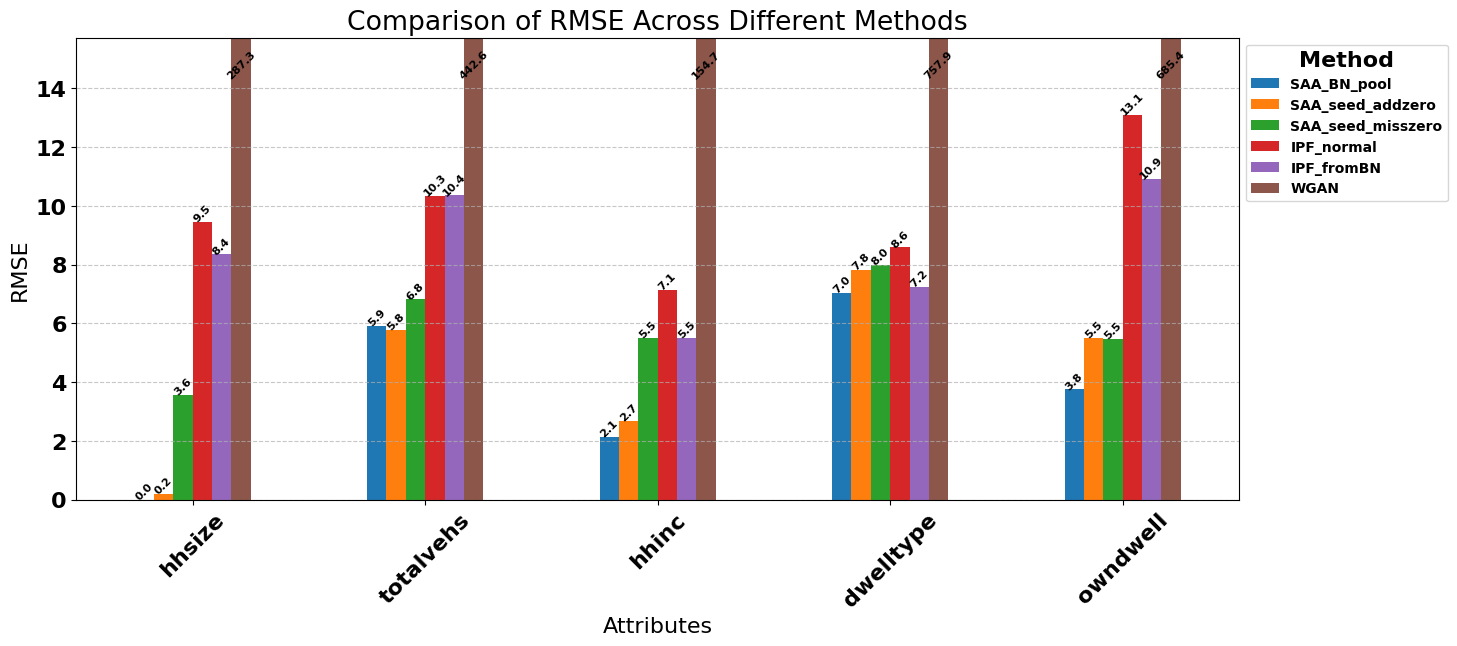

In [20]:
last_order = ["hhsize", "totalvehs", "hhinc", "dwelltype", "owndwell"]
# Plot grouped bar chart
# Exclude WGAN from y-axis scaling
max_value = fin_atts_rmse.drop(columns=['WGAN']).max().max()  # Get max RMSE excluding WGAN
ax = fin_atts_rmse.reindex(last_order).plot(kind='bar', figsize=(15, 6))

# Formatting the plot
plt.xlabel("Attributes")
plt.ylabel("RMSE")
plt.title("Comparison of RMSE Across Different Methods")
# plt.legend(title="Method")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Method", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# **Set y-axis limit to ignore WGAN's extreme value**
plt.ylim(0, max_value * 1.2)  # Increase slightly for better visibility

# **Annotate all bars: WGAN in red, others in black**
for container, col in zip(ax.containers, fin_atts_rmse.columns):
    for bar in container:
        height = bar.get_height()
        if height > 0:  # Avoid labeling zero values
            color = 'black' if col == 'WGAN' else 'black'
            display_height = min(height, plt.ylim()[1] * 0.91)  # Prevent label from going outside the plot
            ax.annotate(f'{height:.1f}', 
                        (bar.get_x() + bar.get_width() / 2, display_height),  
                        ha='center', fontsize=8, color=color, rotation=45)

# Show plot
plt.show()

In [21]:
fin_atts_rmse.mean()

SAA_BN_pool            3.768061
SAA_seed_addzero       4.400326
SAA_seed_misszero      5.871361
IPF_normal             9.723871
IPF_fromBN             8.472670
WGAN                 465.557241
dtype: float64

### Look closer at income

In [22]:
income_order = [
  "Negative income",
  "1-149",
  "150-299",
  "300-399",
  "400-499",
  "500-649",
  "650-799",
  "800-999",
  "1000-1249",
  "1250-1499",
  "1500-1749",
  "1750-1999",
  "2000-2499",
  "2500-2999",
  "3000-3499",
  "3500-3999",
  "4000-4499",
  "4500-4999",
  "5000-5999",
  "6000-7999",
  "8000+"
]


<Axes: xlabel='hhinc', ylabel='RMSE'>

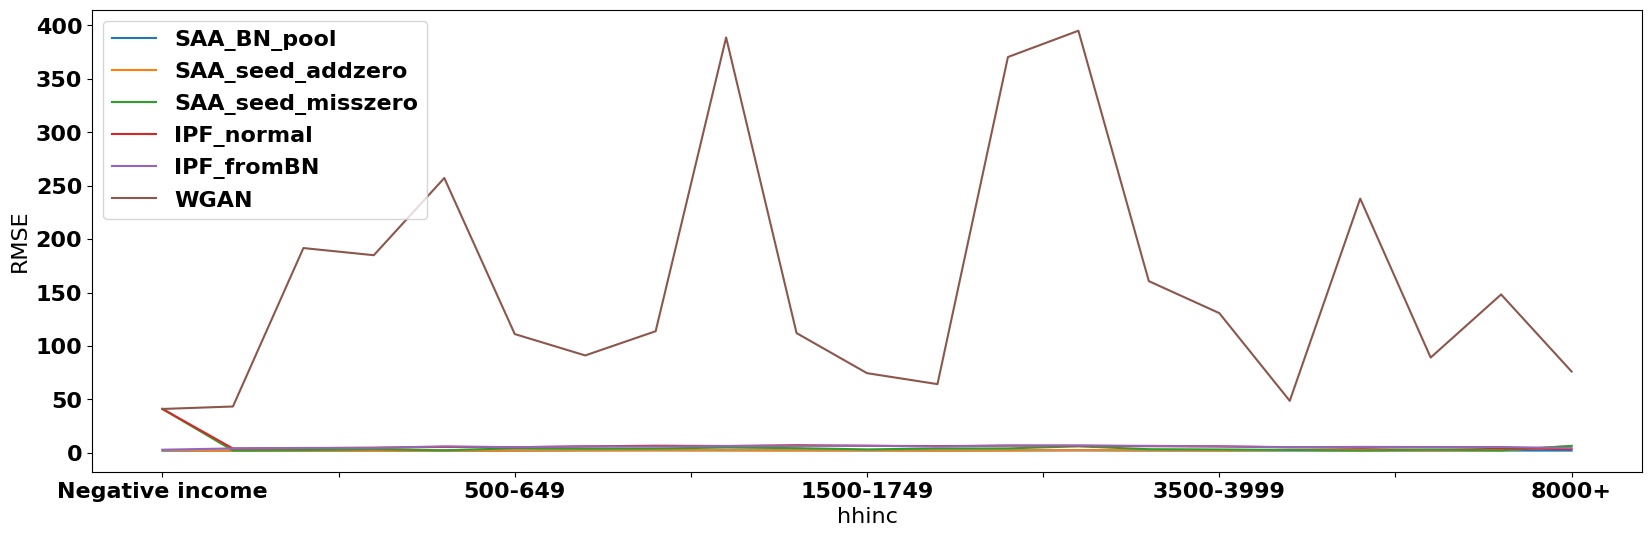

In [23]:
a = converted_atts_rmse.reset_index()
a = a[a["Attribute"] == "hhinc"].drop(columns=["Attribute"])
a = a.set_index("State")
a = a.drop(index="Nil income")
a.reindex(income_order).plot(kind='line', figsize=(20, 6), xlabel="hhinc", ylabel="RMSE")
# a.reindex(income_order)